# How to Find the Optimal Location for a Pair of Virtual Fence Base Stations

## Requirements

This Jupyter Notebook is intended to be run inside of ArcGIS Pro with the Spatial Analysis extension/license. It is not intended to be run in a Jupyter Notebook outside of ArcGIS Pro. If you are not familiar with the ArcGIS Pro ArcPy package, please view the [What is ArcPy?](https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/what-is-arcpy-.htm).

License Requirements:
    ArcGIS Pro >3.0
    Spatial Analyst Extension

You must have ArcGIS Pro installed on your computer to run this notebook, and you must have the Spatial Analyst extension enabled.

## How to Download this Notebook

To download this project as a .zip file:

Go to [OptimalVisibilityTool](https://github.com/lilymcmullen/OptimalVisibilityTool) on GitHub. Click the green "<> Code" button near the top right and then select "Download ZIP".

Or you can download the repo using git in a terminal:

```
git clone https://github.com/lilymcmullen/OptimalVisibilityTool.git
```

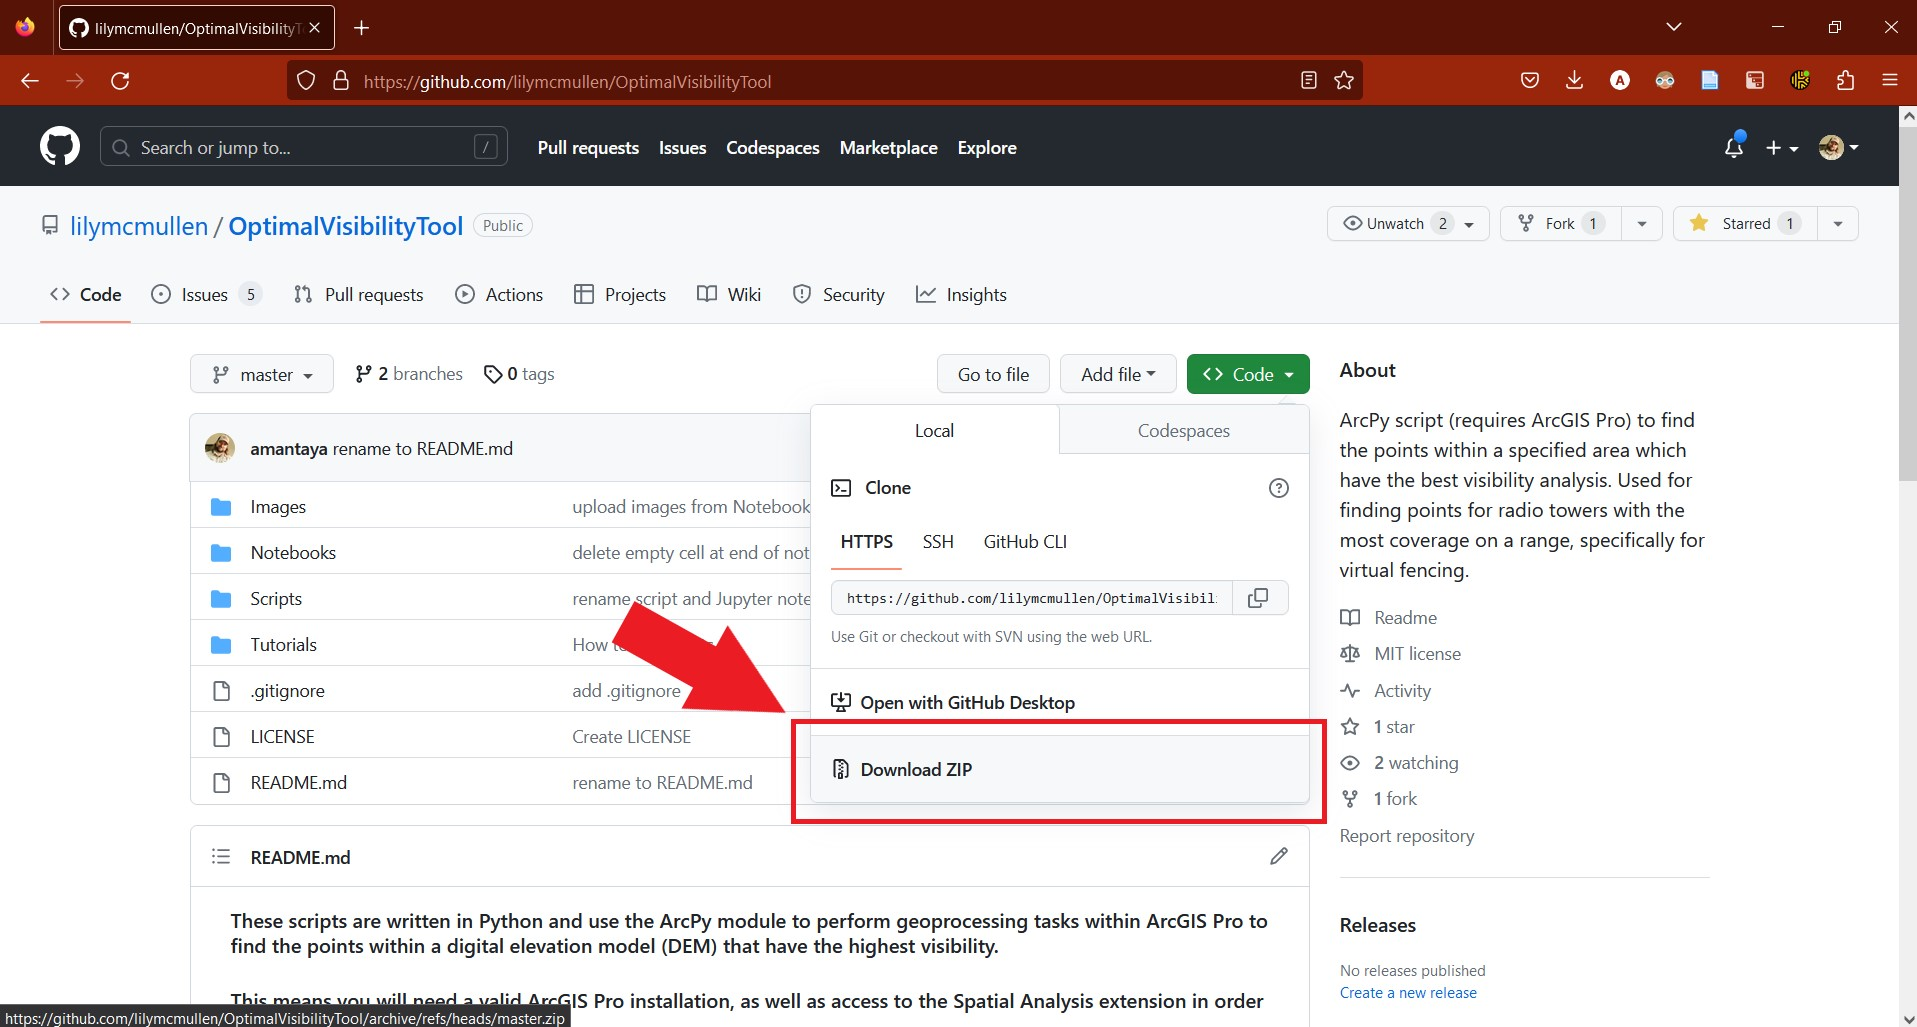

## How To Open This Notebook in ArcGIS Pro

1. Open ArcGIS Pro and create a new ArcGIS project inside of the folder you downloaded from GitHub.

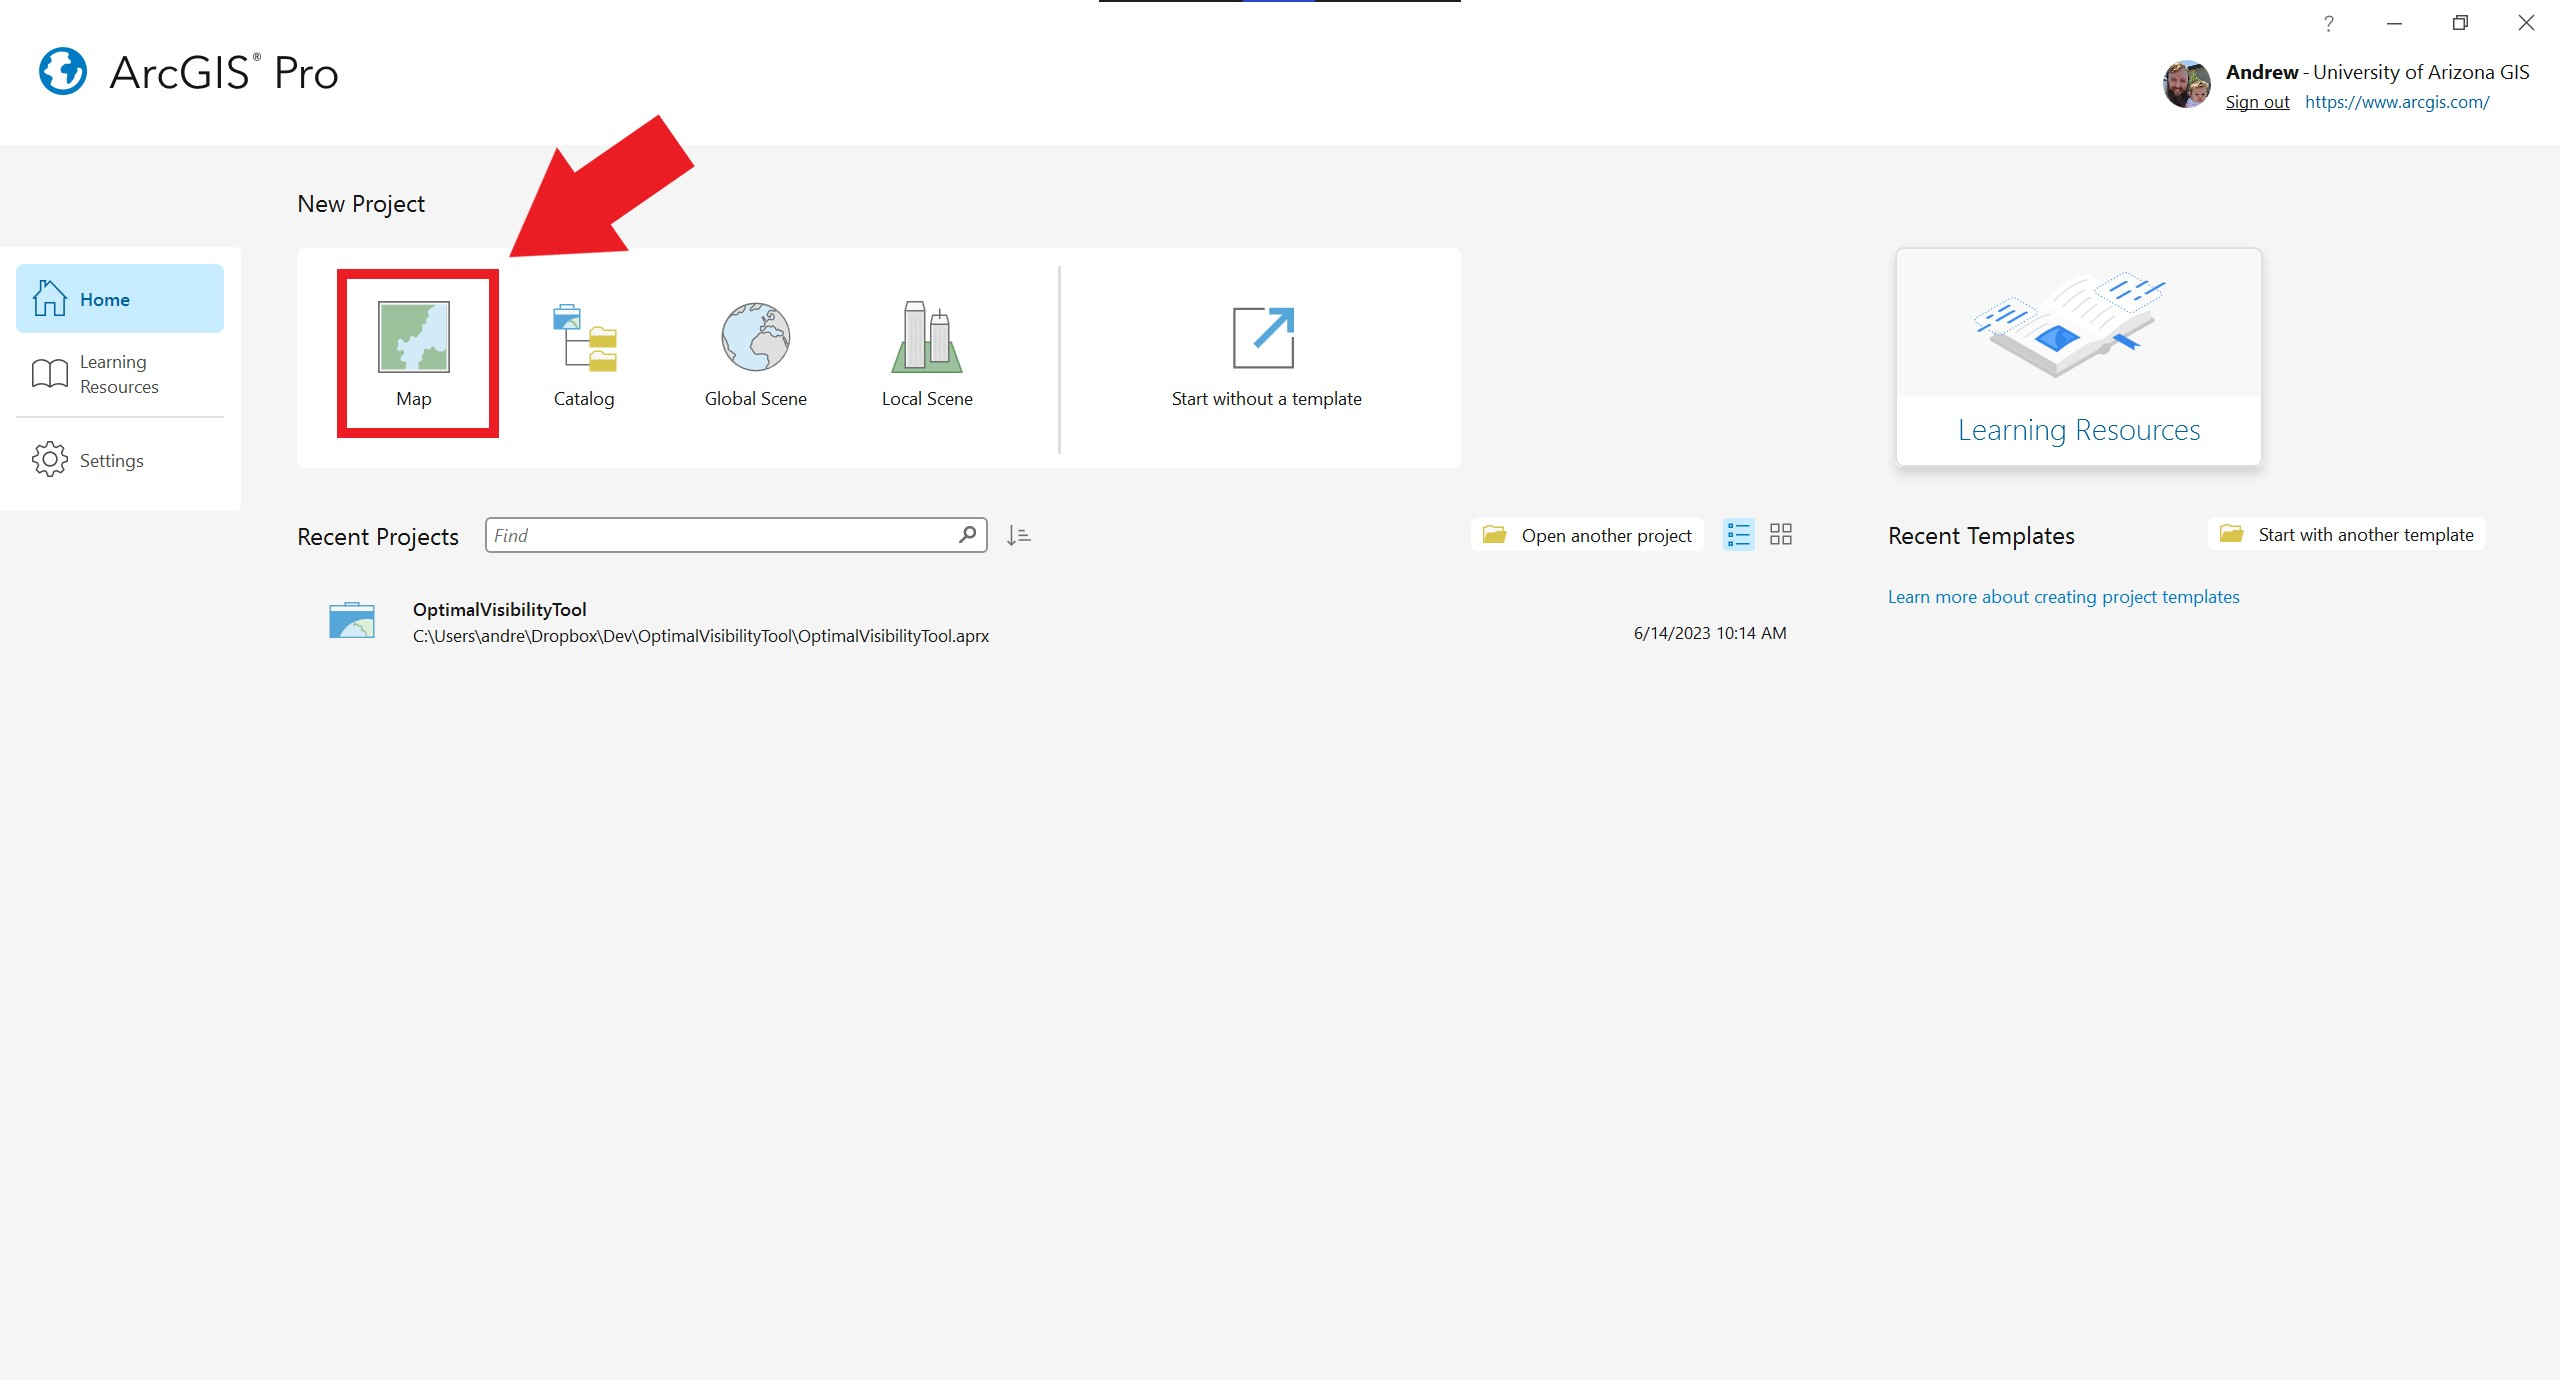

Create a new ArcGIS project inside of the folder you downloaded from GitHub. Naming the project file whatever you would like, such as `OptimalVisibilityTool`. Uncheck the box "Make New Folder". 

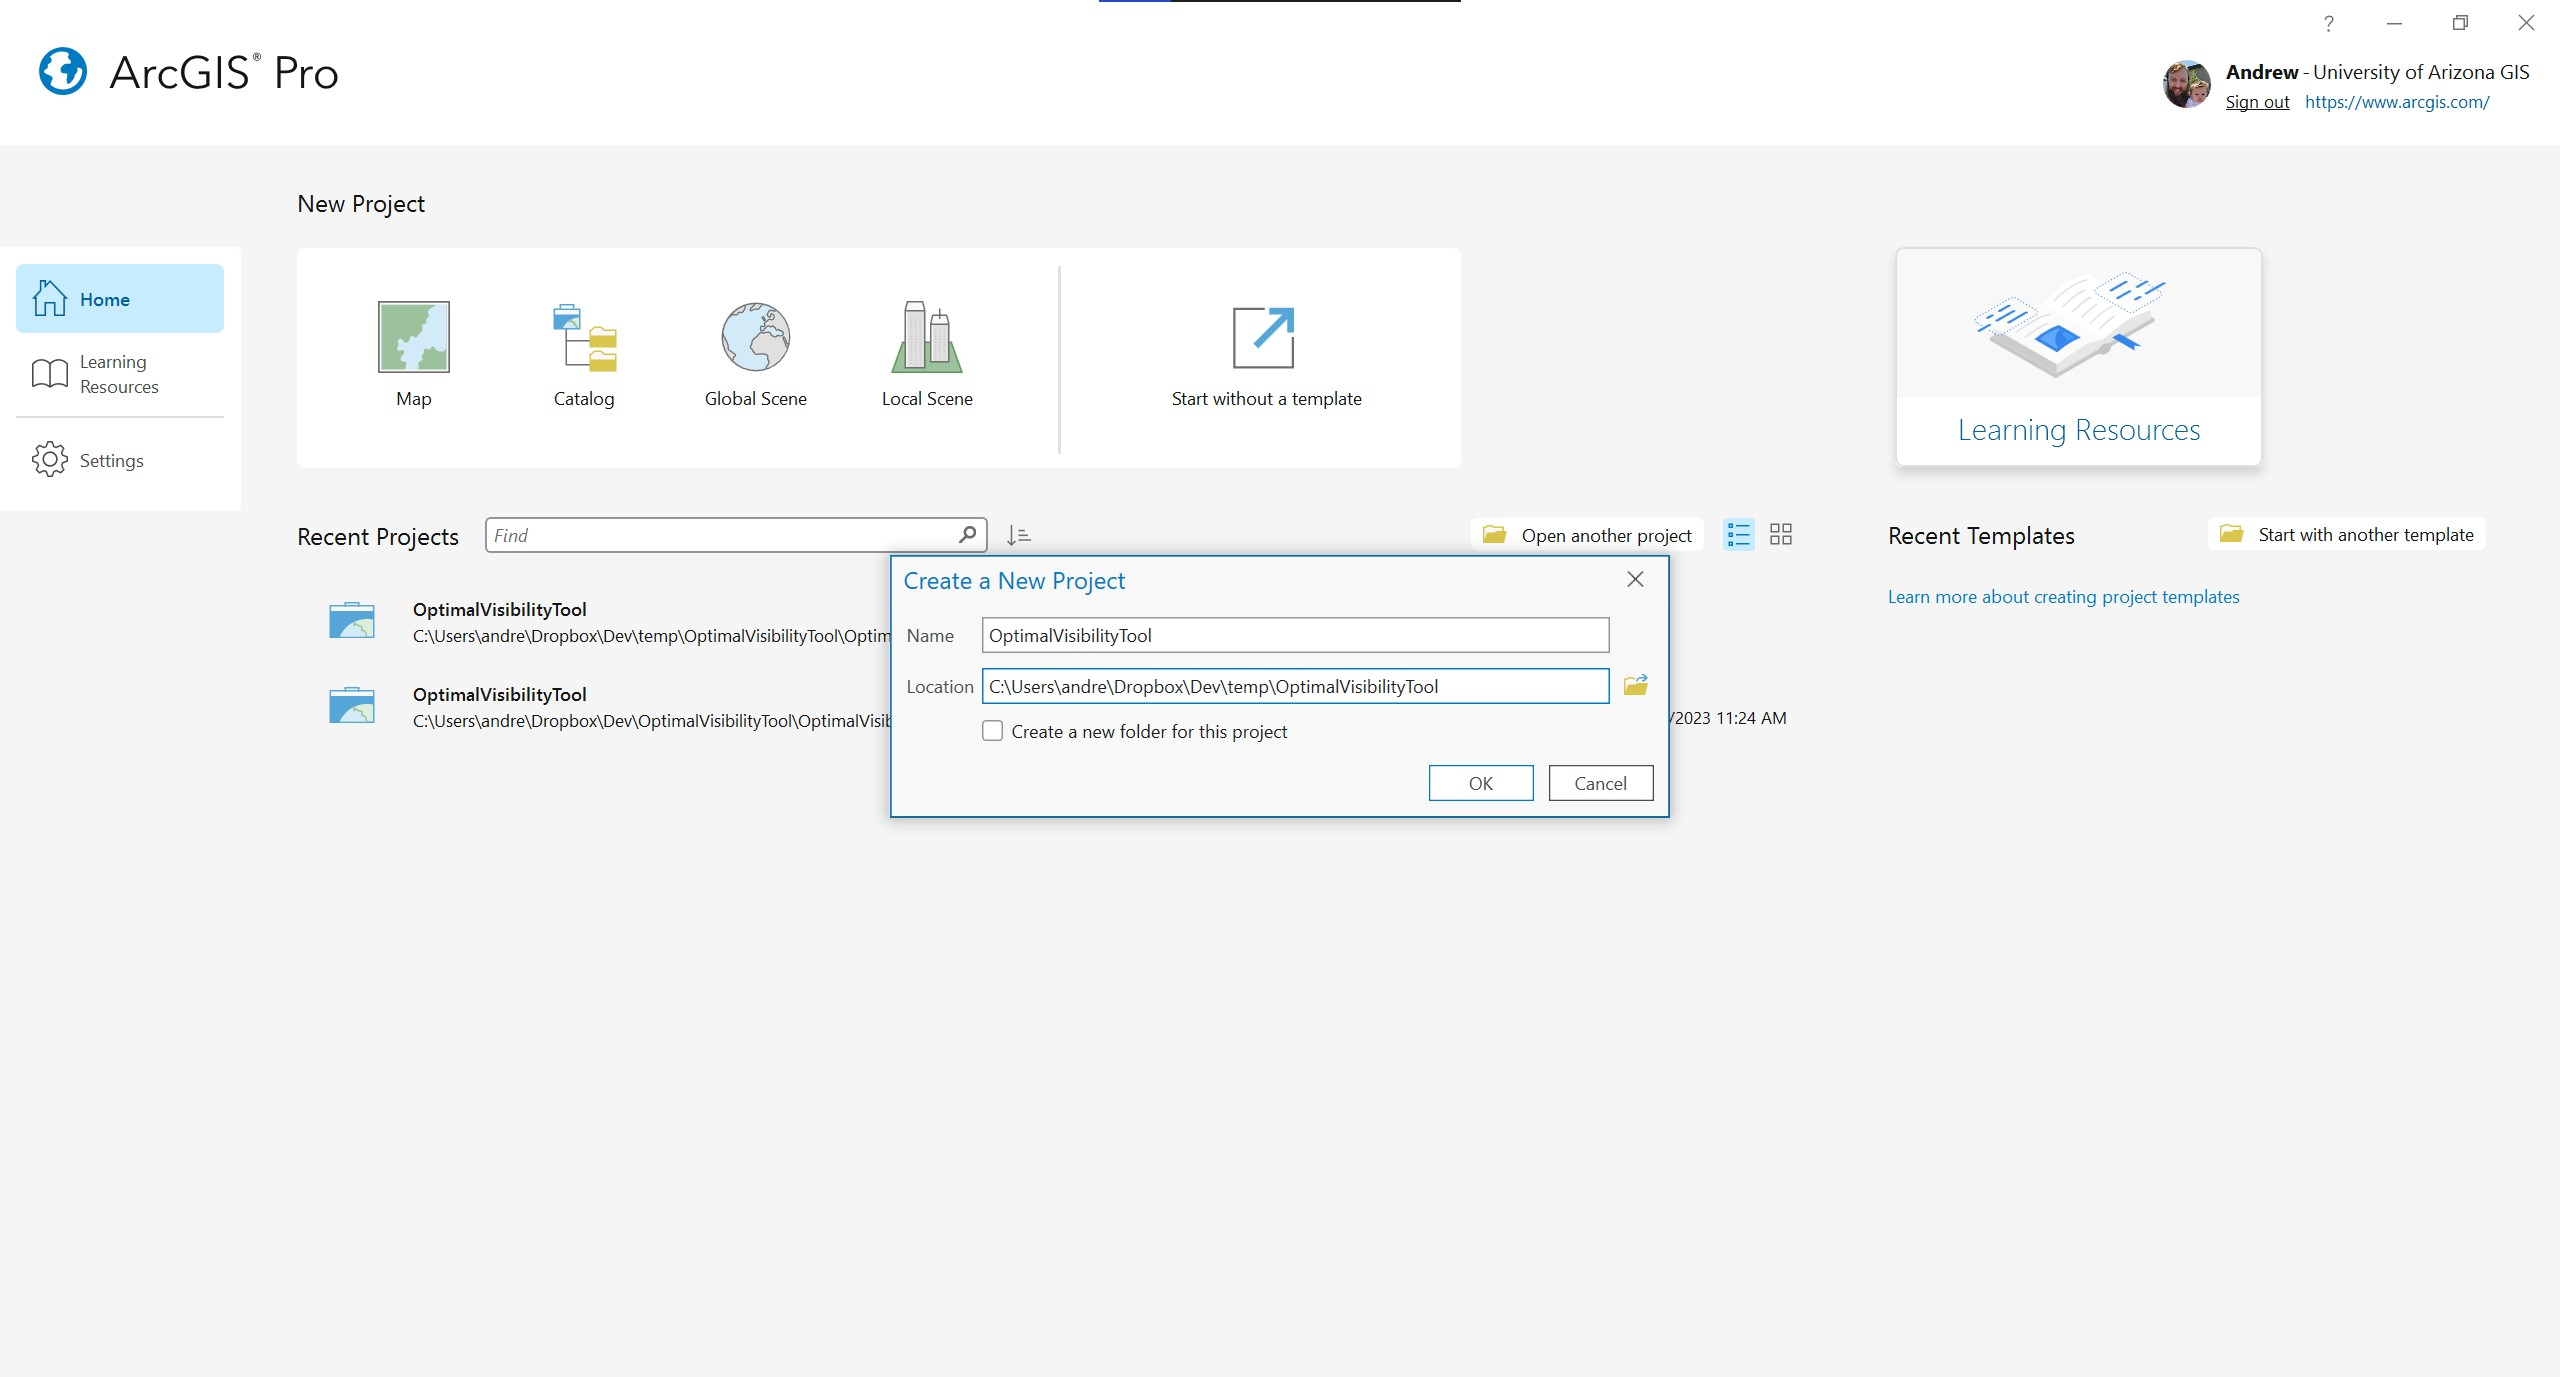

2. Under the "Catalog" pane on the right-side of the Map screen, under the "Project" tab, double-click on "Folders" to expand the ArcGIS project folder. Then double-click on "Notebooks" to open the Notebooks folder. If you don't see any folders inside of the ArcGIS project folder, check to see if the ArcGIS project folder is inside of the folder you downloaded from GitHub. Move the ArcGIS project files into the folder you downloaded from GitHub if necessary.

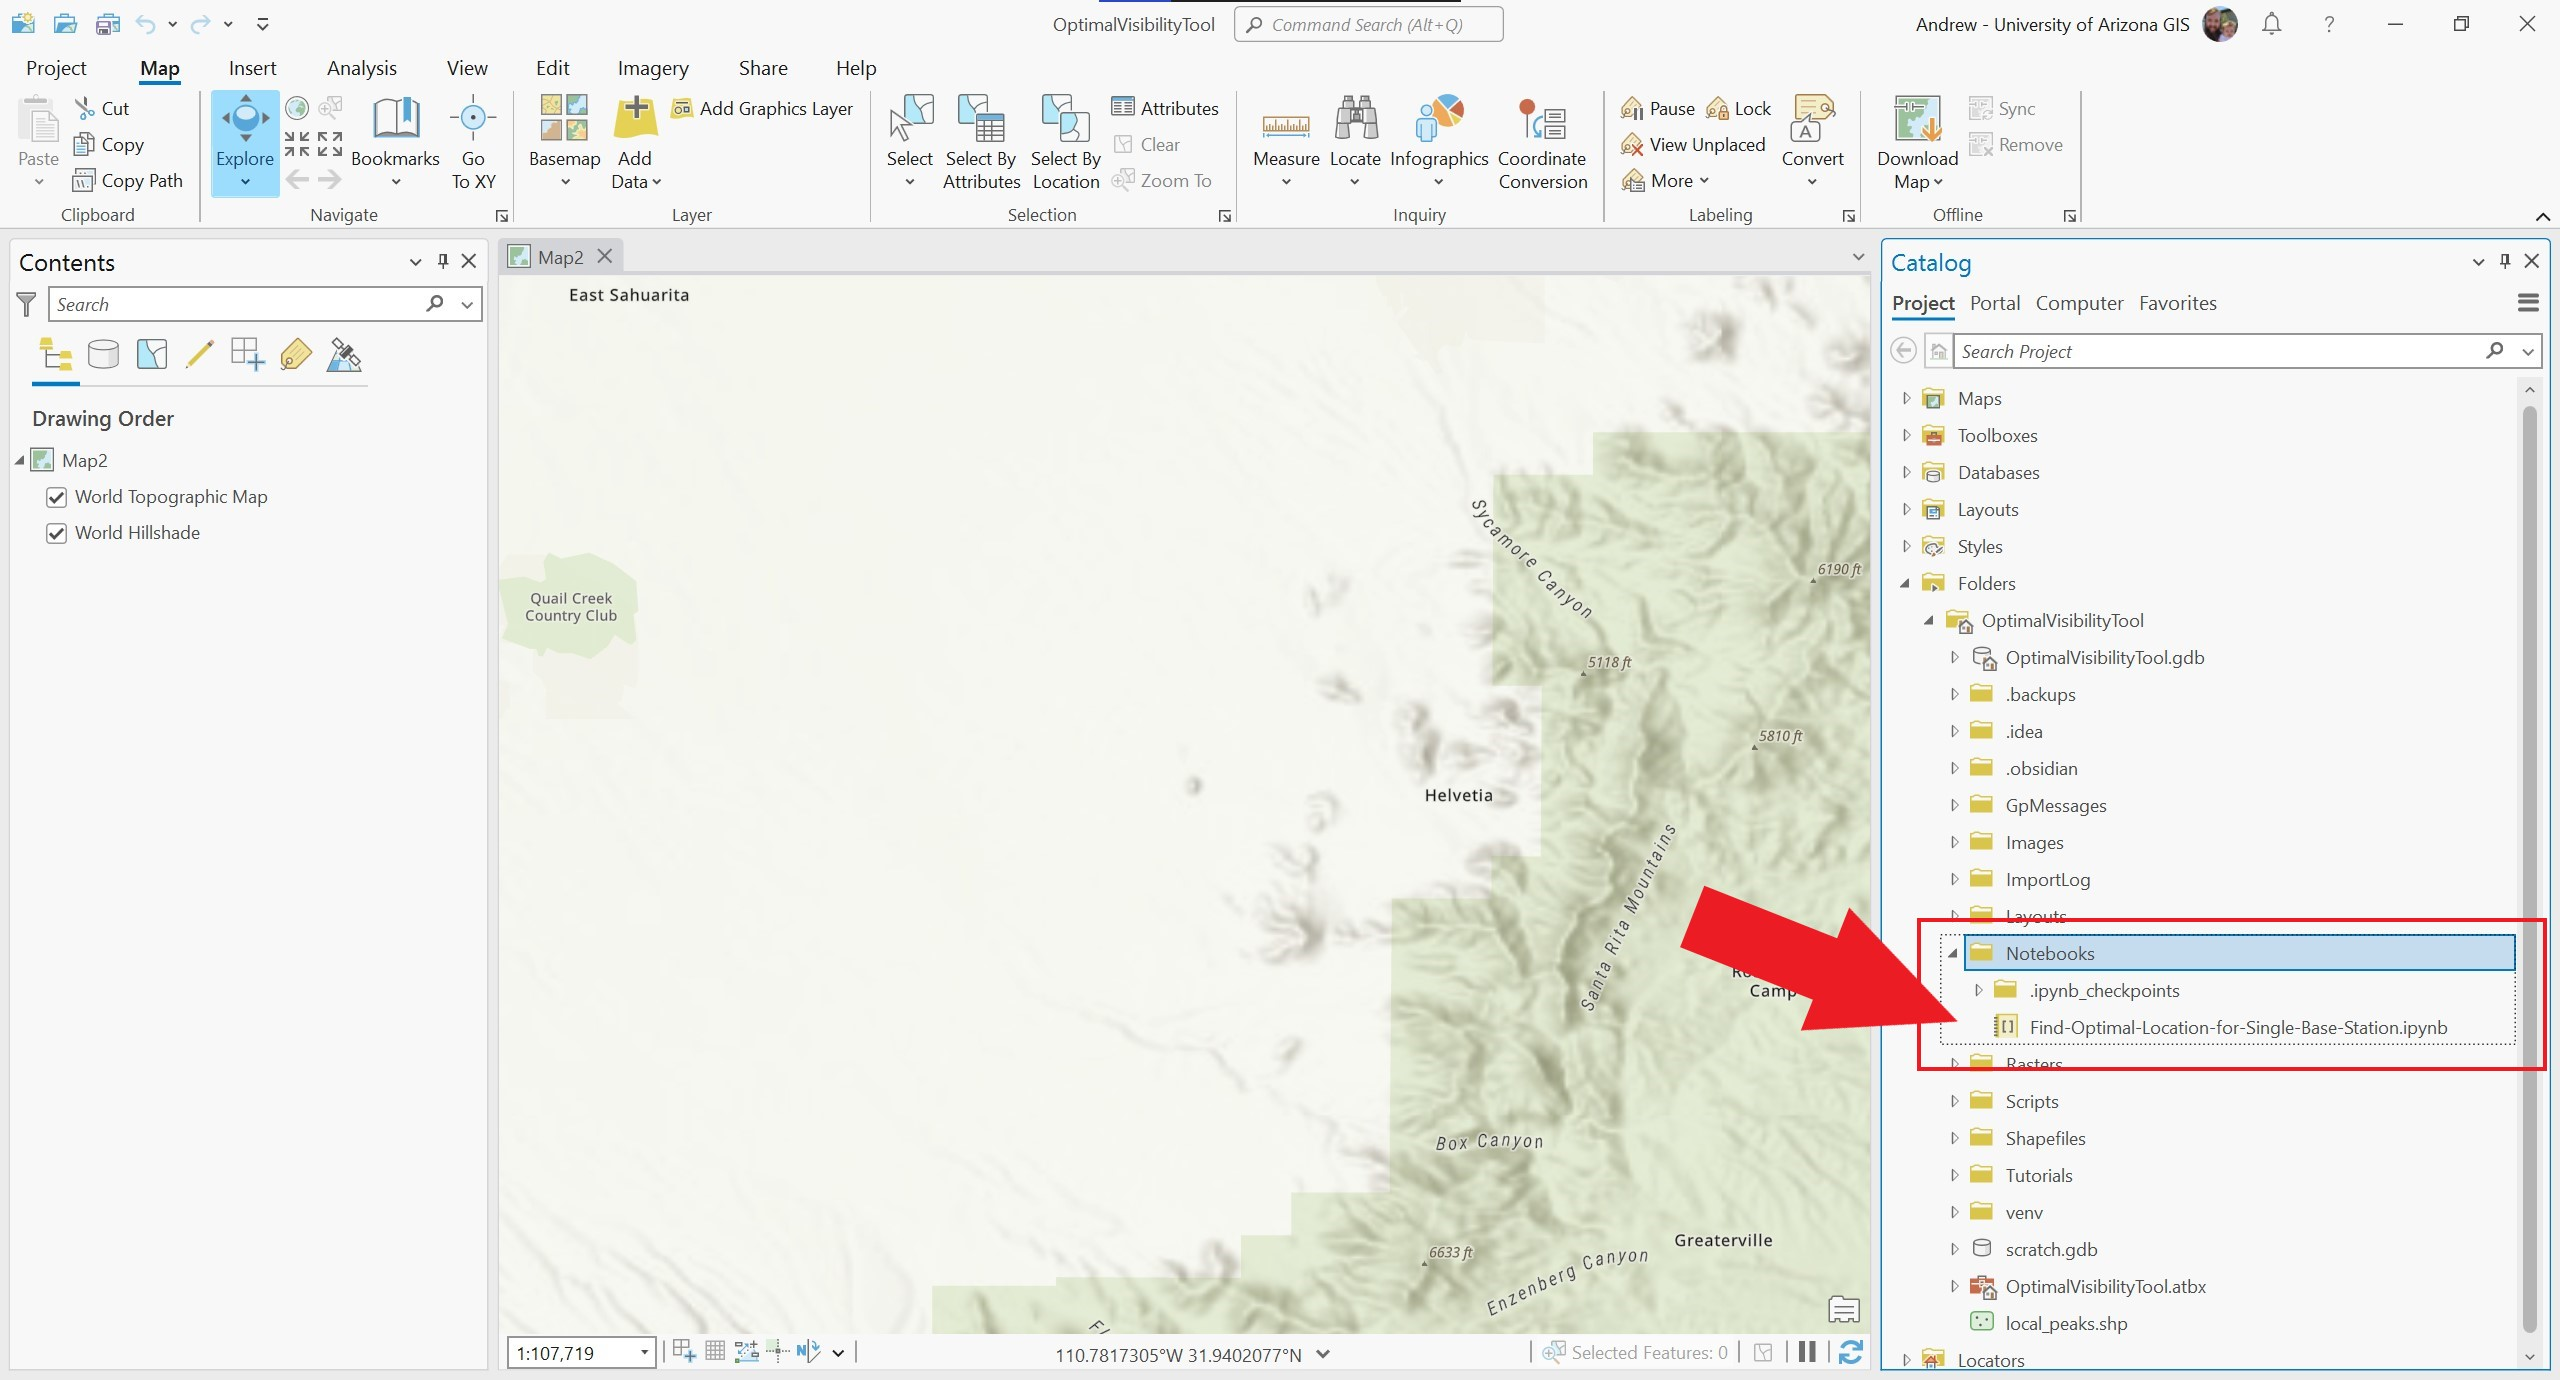

3. Double-click on the Jupyter notebook file you want to open within the "Notebooks" folder. In this case, we want to open the `Find-Optimal-Location-for-Pair-of-Base-Stations.ipynb` file.
4. The Jupyter Notebook will open in a new tab in ArcGIS Pro. You can now run the notebook inside of ArcGIS pro.

## How to Run This Analysis in ArcGIS Pro

Now that you've opened the Jupyter Notebook in ArcGIS Pro, you may need to edit some of the lines of code to change the shapefile and DEM (digital elevation model) for your area. By default, it includes example files for the Santa Rita Experimental Range in Arizona, USA.

To run each code chunk, click the "Run" button at the top of the screen. You can also run a code chunk by clicking inside of the code chunk and then pressing "Shift + Enter" on your keyboard.

In [209]:
# import required packages
import arcpy
from arcpy.sa import *
import pandas as pd
import os

# Set ArcPy workspace - use the current location of this Notebook
# Or edit this line with the path to your ArcGIS project folder
arcpy.env.workspace = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool"

# Allow ArcPy to overwrite previous outputs
# Prevents a file permission error if you re-run this notebook multiple times
arcpy.env.overwriteOutput = True

View [HowToFindFilePaths.md](https://github.com/lilymcmullen/OptimalVisibilityTool/blob/master/Tutorials/HowToFindFilePaths.md) on GitHub for help with file paths.

In [210]:
# Set your Python working directory - use the current location of this Notebook
# Or edit this line with the path to your ArcGIS project folder
os.chdir(r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool")

# View your current working directory to check the location is correct
cwd = os.getcwd()
print(cwd)

c:\users\andre\dropbox\dev\optimalvisibilitytool


In [211]:
# Set the location of the output rasters - defaults to "Rasters" folder 
# Or edit this line with the path to your desired output raster folder
raster_folder = os.path.join(cwd, "Rasters")
print(raster_folder)

c:\users\andre\dropbox\dev\optimalvisibilitytool\Rasters


In [212]:
# Set the location of the input DEM
# Or edit this line with the path to your area's DEM (digital elevation model)
input_raster = os.path.join(raster_folder, "SRER.tif")
print(input_raster)

c:\users\andre\dropbox\dev\optimalvisibilitytool\Rasters\SRER.tif


View [HowToFindYourDEM.md](https://github.com/lilymcmullen/OptimalVisibilityTool/blob/master/Tutorials/HowToFindYourDEM.md) on GitHub for help with finding a DEM for your area.

In [213]:
# Or edit this line with a path to the shapefile of your area's boundaries
boundary_shapefile = os.path.join(cwd, "Shapefiles", "srerboundary", "bounds.shp")
print(boundary_shapefile)

c:\users\andre\dropbox\dev\optimalvisibilitytool\Shapefiles\srerboundary\bounds.shp


If you have permission to place a virtual fence base station on land surrounding your area, such as on a nearby mountain that may not be within your grazing area, use a shapefile that includes those potential areas outside of your grazing area. Doing so will give you more potential placements for your virtual fence base station and likely will give you better radio coverage.

In [214]:
# Crop your DEM by your area's boundary shapefile
# Constrains the analysis to only consider the area within your boundary shapefile
cropped_raster = ExtractByMask(input_raster, boundary_shapefile)

# Save the cropped raster to a .tif file
cropped_raster.save(
    os.path.join(raster_folder, "cropped_raster.tif")
    )

You can switch to the "Map" tab to view the cropped raster.

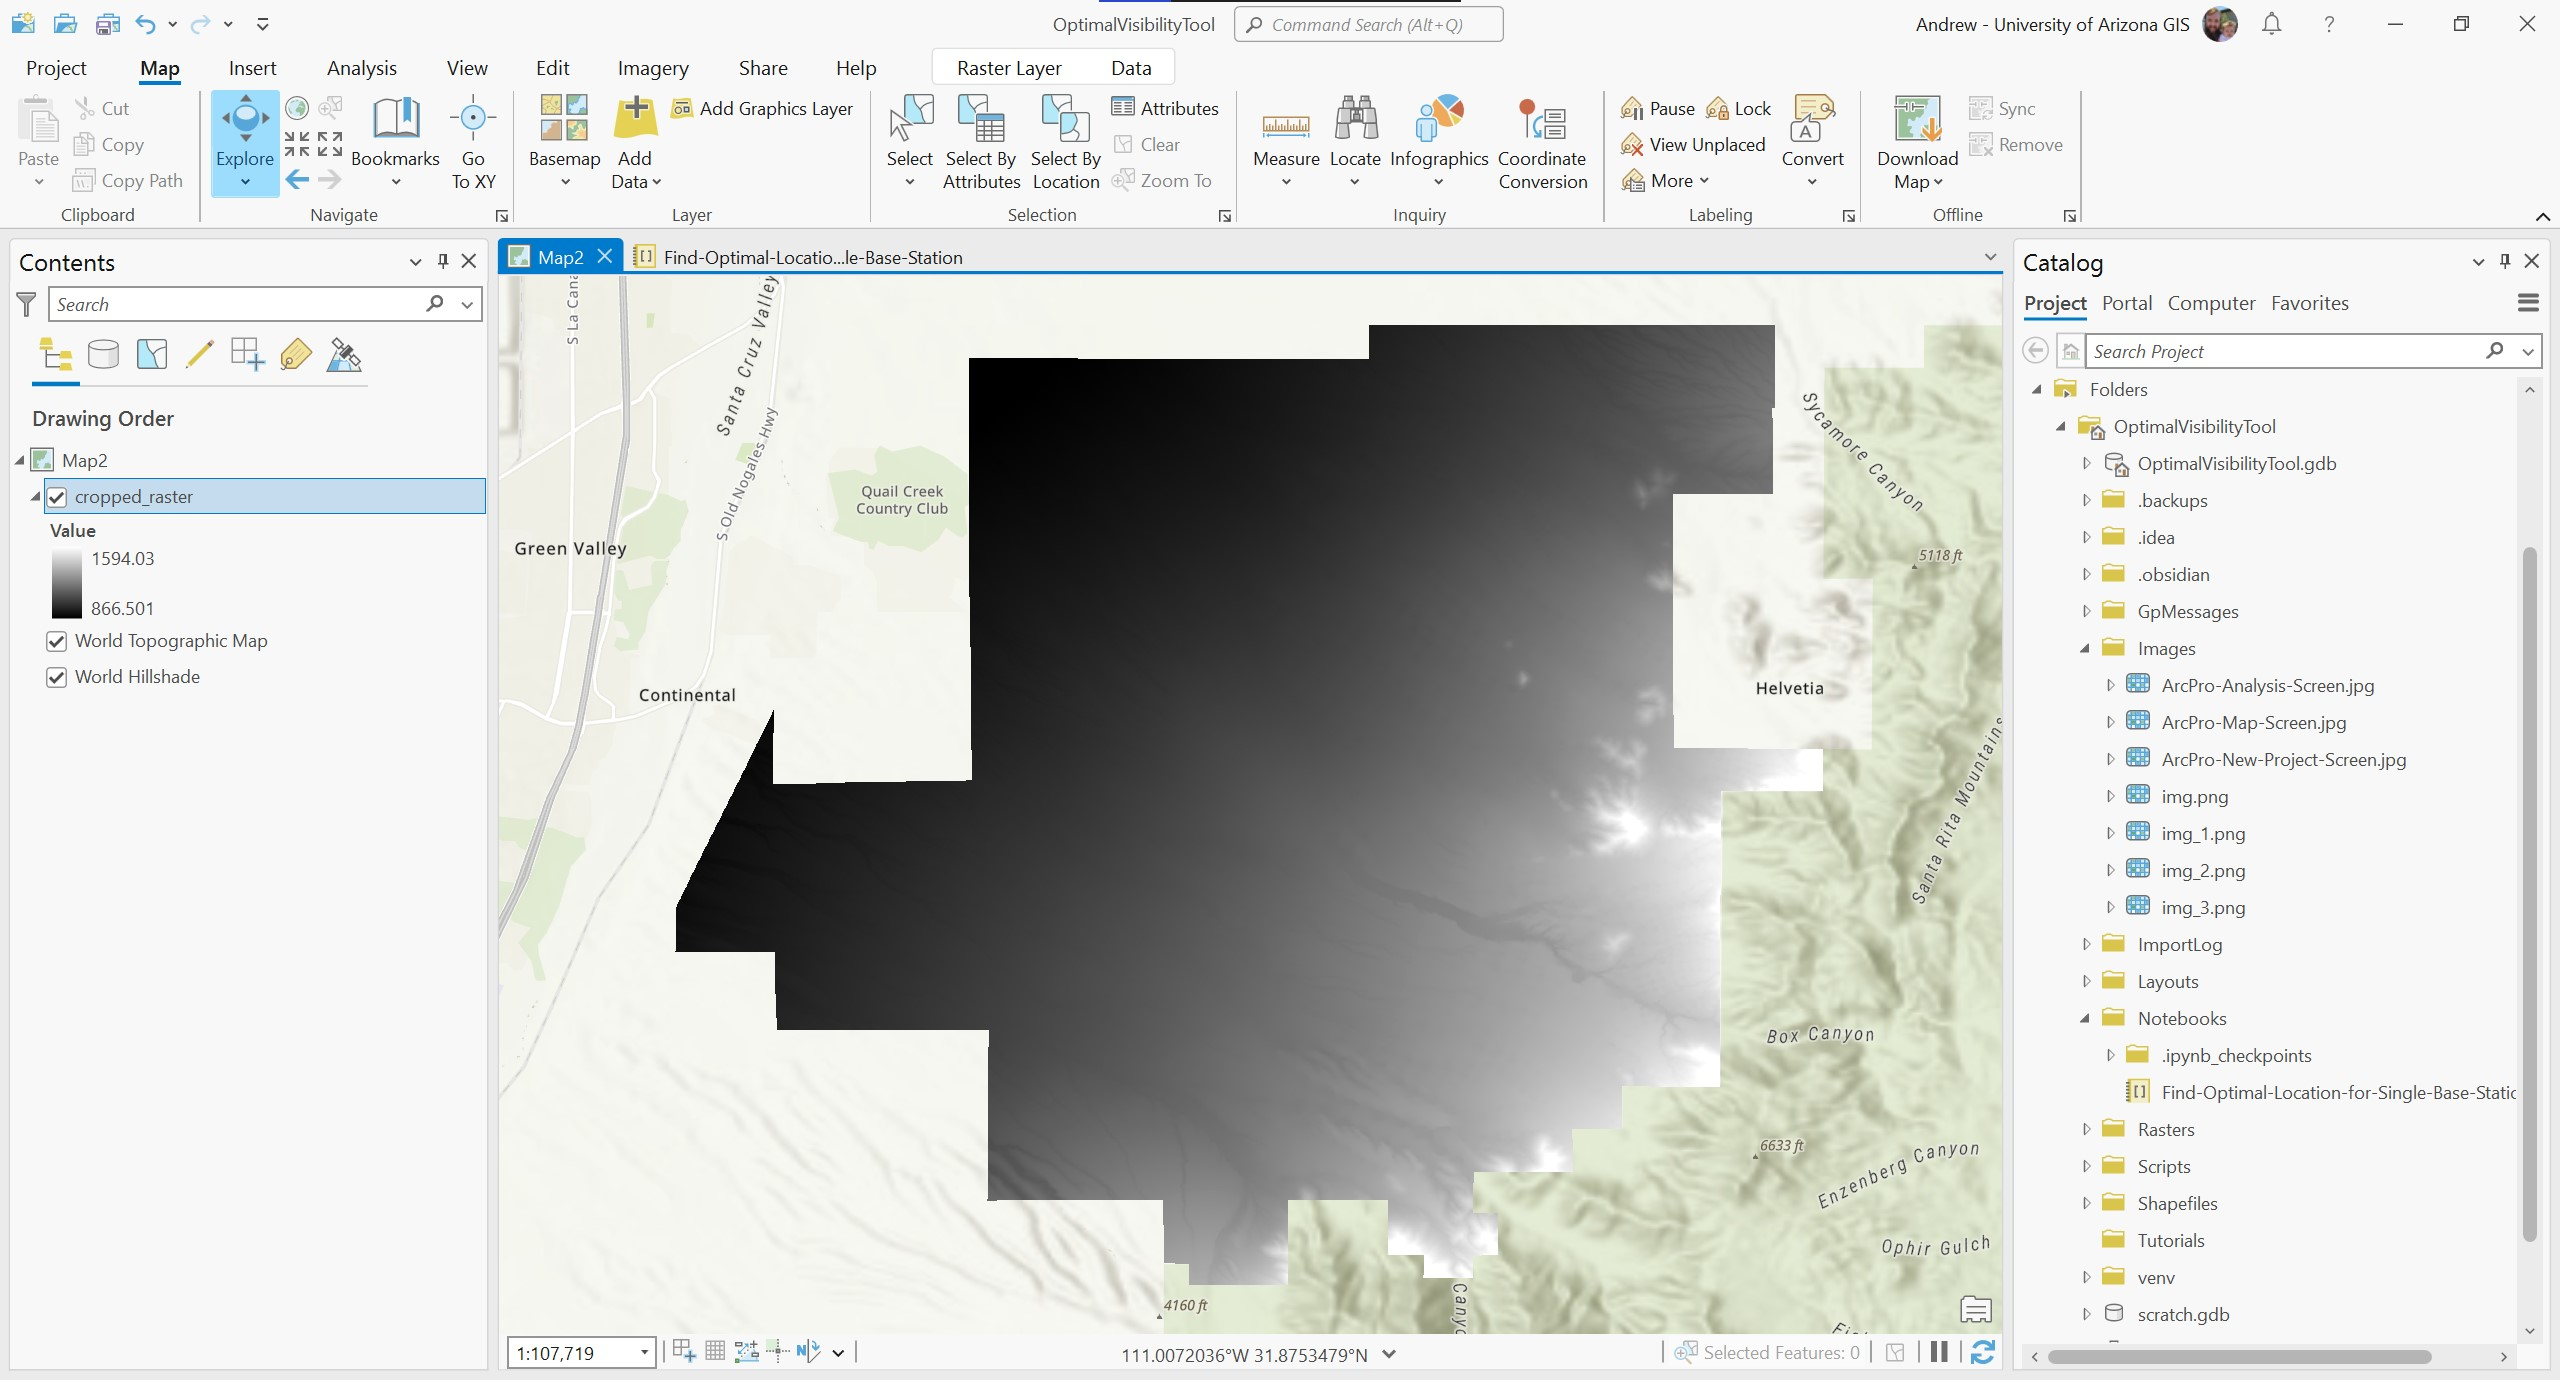

The next code chunk will find local peaks within the cropped raster. We will use these peaks to analyze as potential placements for base stations. The default is 5 points, but you can set this higher to consider more points, and lower for faster processing time.

In [215]:
# Find local peaks within the cropped raster
# Default is 5 points, but set higher to consider more points, and lower for faster processing time
local_peaks = arcpy.defense.FindLocalPeaksValleys(
    cropped_raster, 
    "local_peaks", 
    "PEAKS", 
    5)

You can switch to the "Map" tab to view the local peaks generated for your area.

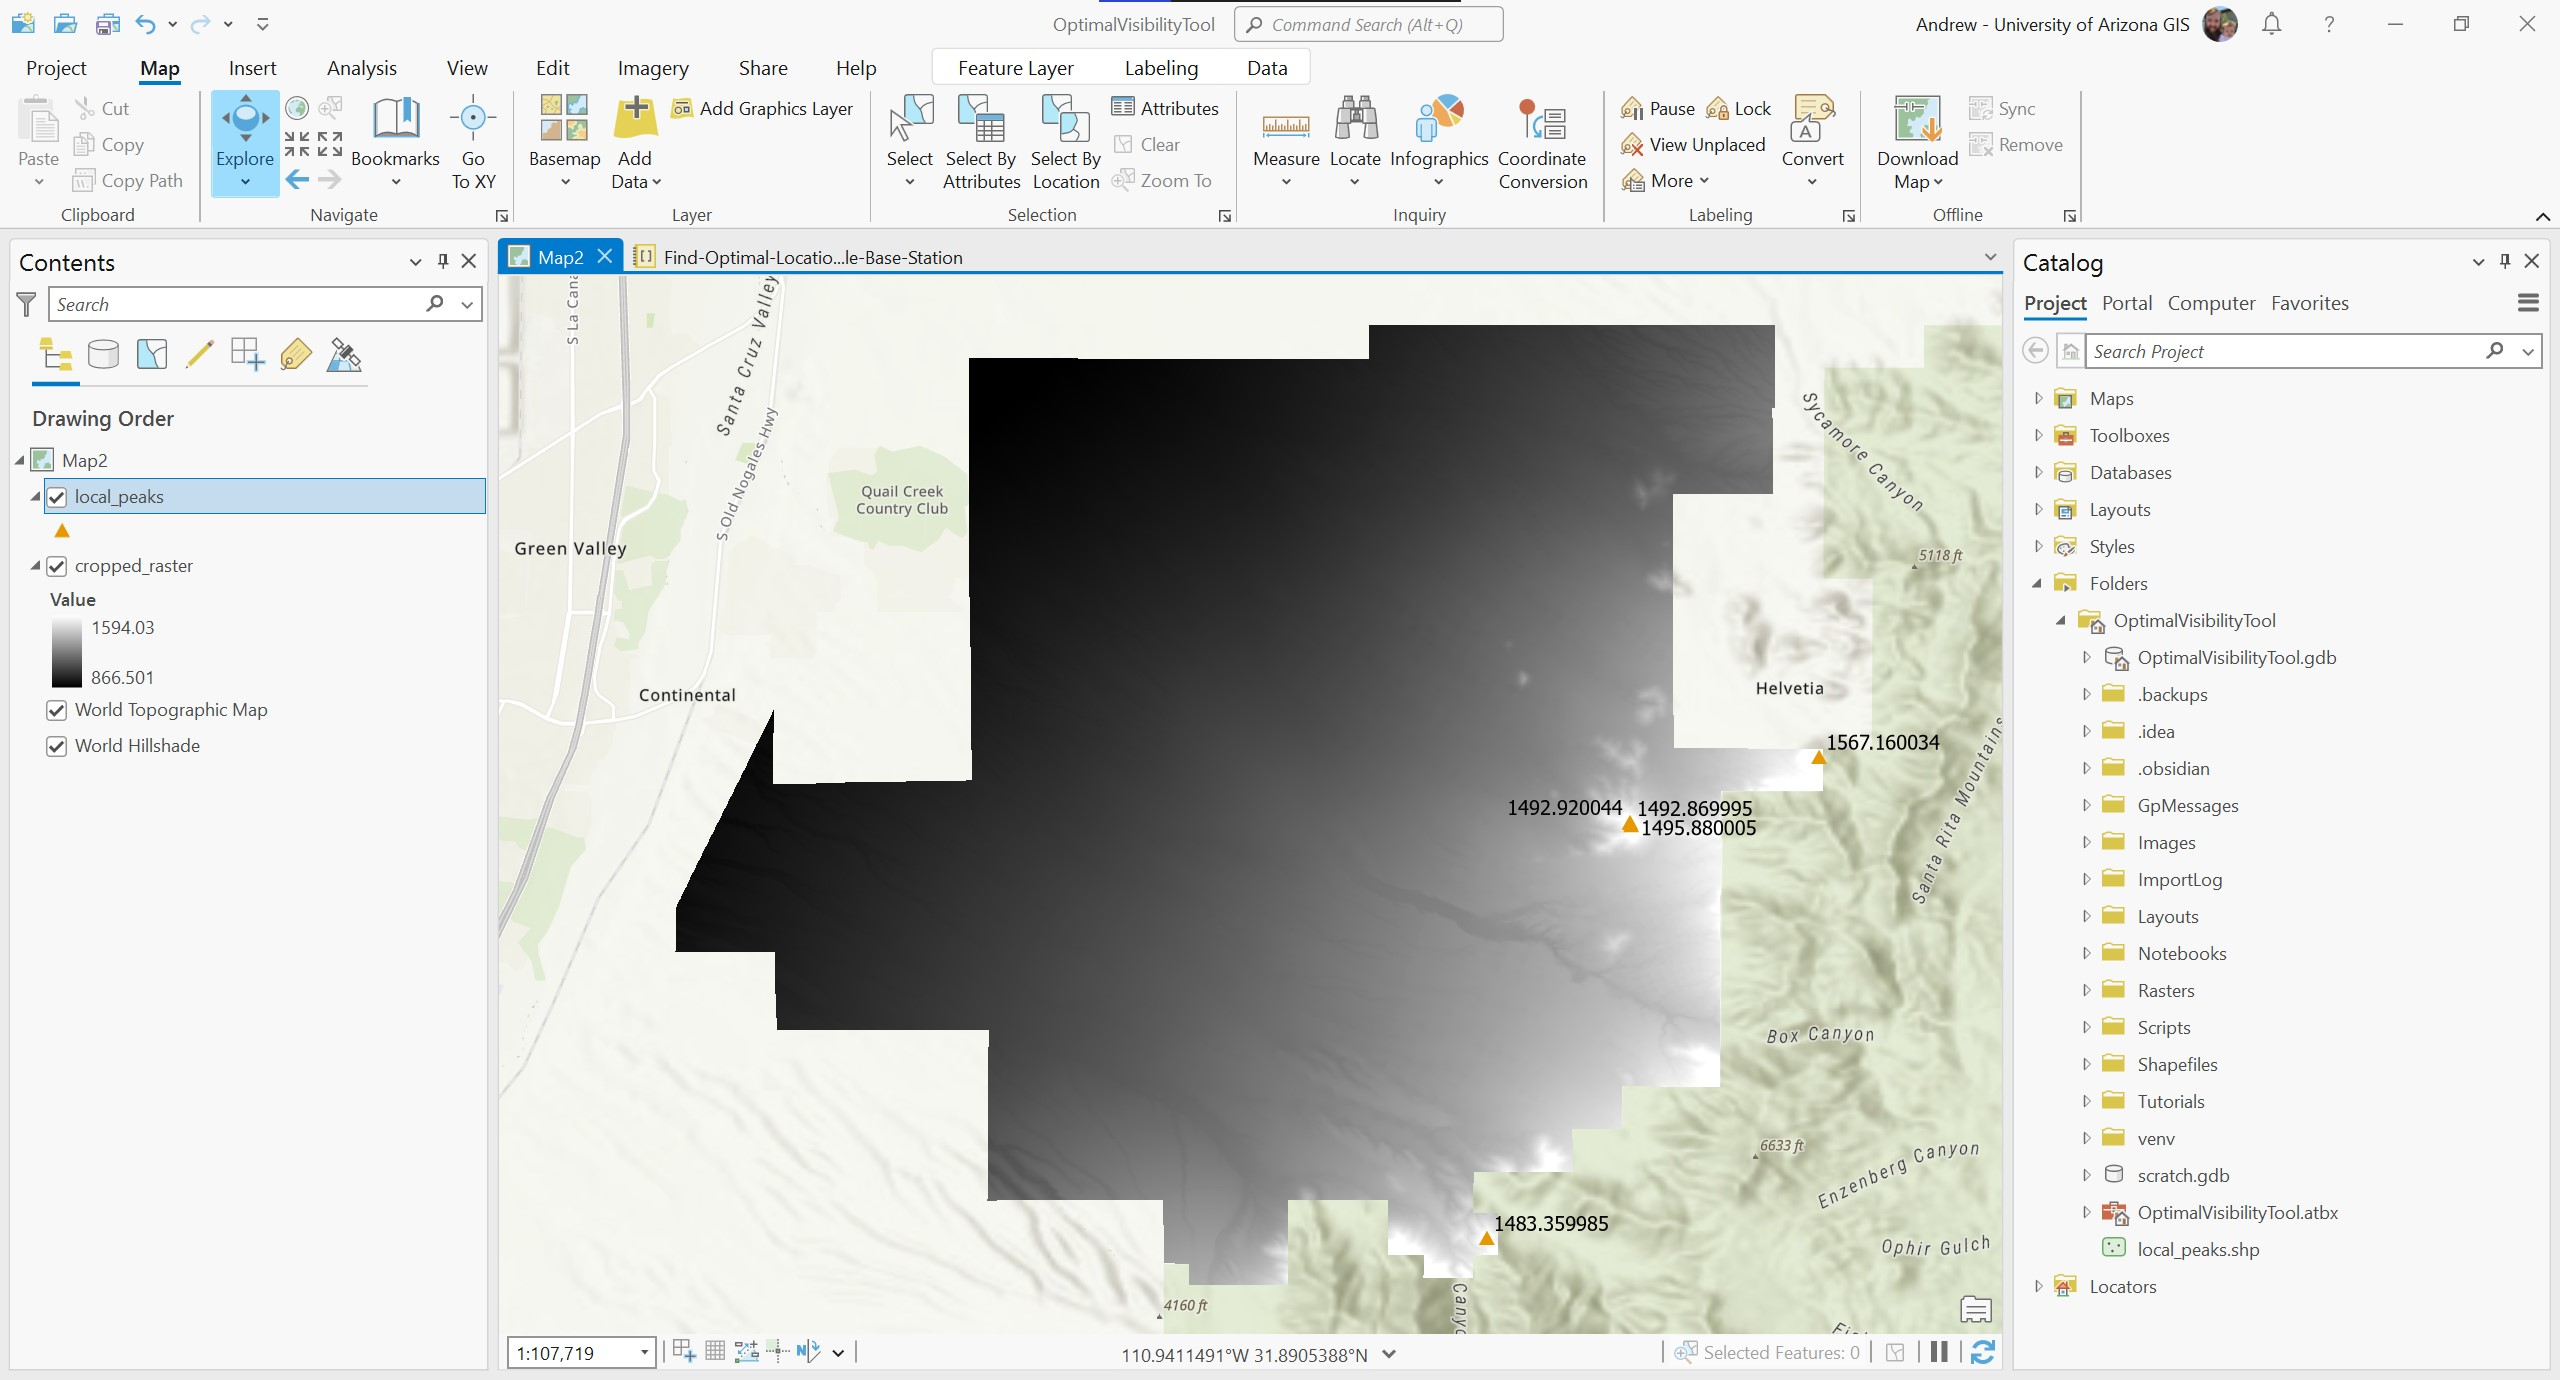

In [216]:
# Create a name for output folder for the visibility analysis 
# You can change the folder name every run to save the analysis from the previous run
# Or leave the folder name the same each run to over-write the previous run 
visibility_analysis_folder_name = "visibility_output_pair"

visibility_analysis_folder_path = os.path.join(raster_folder,
                                                visibility_analysis_folder_name)
print(visibility_analysis_folder_path)

c:\users\andre\dropbox\dev\optimalvisibilitytool\Rasters\visibility_output_pair_11


In [217]:
# Create the new folder to contain the visibility analysis output if it doesn't already exist
if not os.path.isdir(visibility_analysis_folder_path):
    try:
        os.mkdir(visibility_analysis_folder_path)
    except OSError as error:
        print(error)

In [218]:
# Select the name of the first field/column from the local_peaks output
field = 'FID'

# List all object IDs from field = 'FID'
all_object_ids = [row[0] for row in arcpy.da.SearchCursor(local_peaks, field)]
print(all_object_ids)

# Find the object ID fieldname
object_id_field = arcpy.Describe(local_peaks).OIDFieldName
print(object_id_field)

[0, 1]
FID


This next code chunk will run a visibility analysis, a 'viewshed', for each of the points in the `local_peaks` shapefile that we generated for our area. The digital elevation model that we cropped with our boundary shapefile will be used to determine the visibility from each `local_peaks` point.

In [219]:
# Loop through each of the points from the local_peaks points
for i in range(len(all_object_ids)-1):  # For each point except the last one
    
    for j in range(i+1, len(all_object_ids)):  # For each point after the current point
    # create a where clause to select only the current point and the next point
        sql = "{0} IN ({1},{2})".format(
        arcpy.AddFieldDelimiters(
            datasource=local_peaks, 
            field=object_id_field), 
        all_object_ids[i],
        all_object_ids[j])
          
        # create a layer with only the local peak point id for iteration of the loop
        arcpy.MakeFeatureLayer_management(
            in_features=local_peaks, 
            out_layer=f"visibility_point_{all_object_ids[i]}_{all_object_ids[j]}",
            where_clause=sql)
    
        # generate a viewshed for the local peak point for each iteration of the loop
        # you can change the observer_offset value to account for the height of the antenna if needed
        # TODO use the visibility from the uncropped raster
        # as the cropped raster may be missing mountains that may block the signal
        last_visibility_output = arcpy.sa.Visibility(cropped_raster, # DEM cropped by your boundary shapefile
                                 f"visibility_point_{all_object_ids[i]}_{all_object_ids[j]}", # single point from the local_peaks points
                                 analysis_type="OBSERVERS", 
                                 nonvisible_cell_value="NODATA", 
                                 observer_offset=6) # observer height in meters
    
        # create a name for each visibility raster using its object ID
        # visibility_analysis_1.tif, visibility_analysis_2.tif etc...
        output_raster_name = os.path.join(visibility_analysis_folder_path,
                                      "visiblity_analysis_{0}_{1}.tif".format(all_object_ids[i], all_object_ids[j])
                                      )
        # save each visibility raster to .tif file
        last_visibility_output.save(output_raster_name)

In [220]:
# change the ArcPy workspace to the visibility analysis output folder
arcpy.env.workspace = visibility_analysis_folder_path

# check that workspace is correct
print(arcpy.env.workspace)

c:\Users\andre\Dropbox\Dev\optimalvisibilitytool\Rasters\visibility_output_pair_11


In [221]:
# create a list of rasters in the visibility_analysis_folder_path
rasters = arcpy.ListRasters()

# load the visibility analysis rasters into ArcGIS for visual comparison
aprx = arcpy.mp.ArcGISProject('CURRENT')
for raster in rasters:
    raster_layer = arcpy.MakeRasterLayer_management(raster, f"{raster}")

Switch to the "Map" tab to view each of the visibility rasters. Each raster corresponds to a single point, i.e. `visibility_analysis_0_1` raster corresponds to `visibility_point_0_1`. Each raster represents the aproximate radio coverage from the corresponding points.

Note: You can remove the `last_visibility_output` raster from the map, as this raster is by-product of saving each raster as a .tif file. The `last_visibilty_output` represents the viewshed from the last point in the `local_peaks` shapefile.

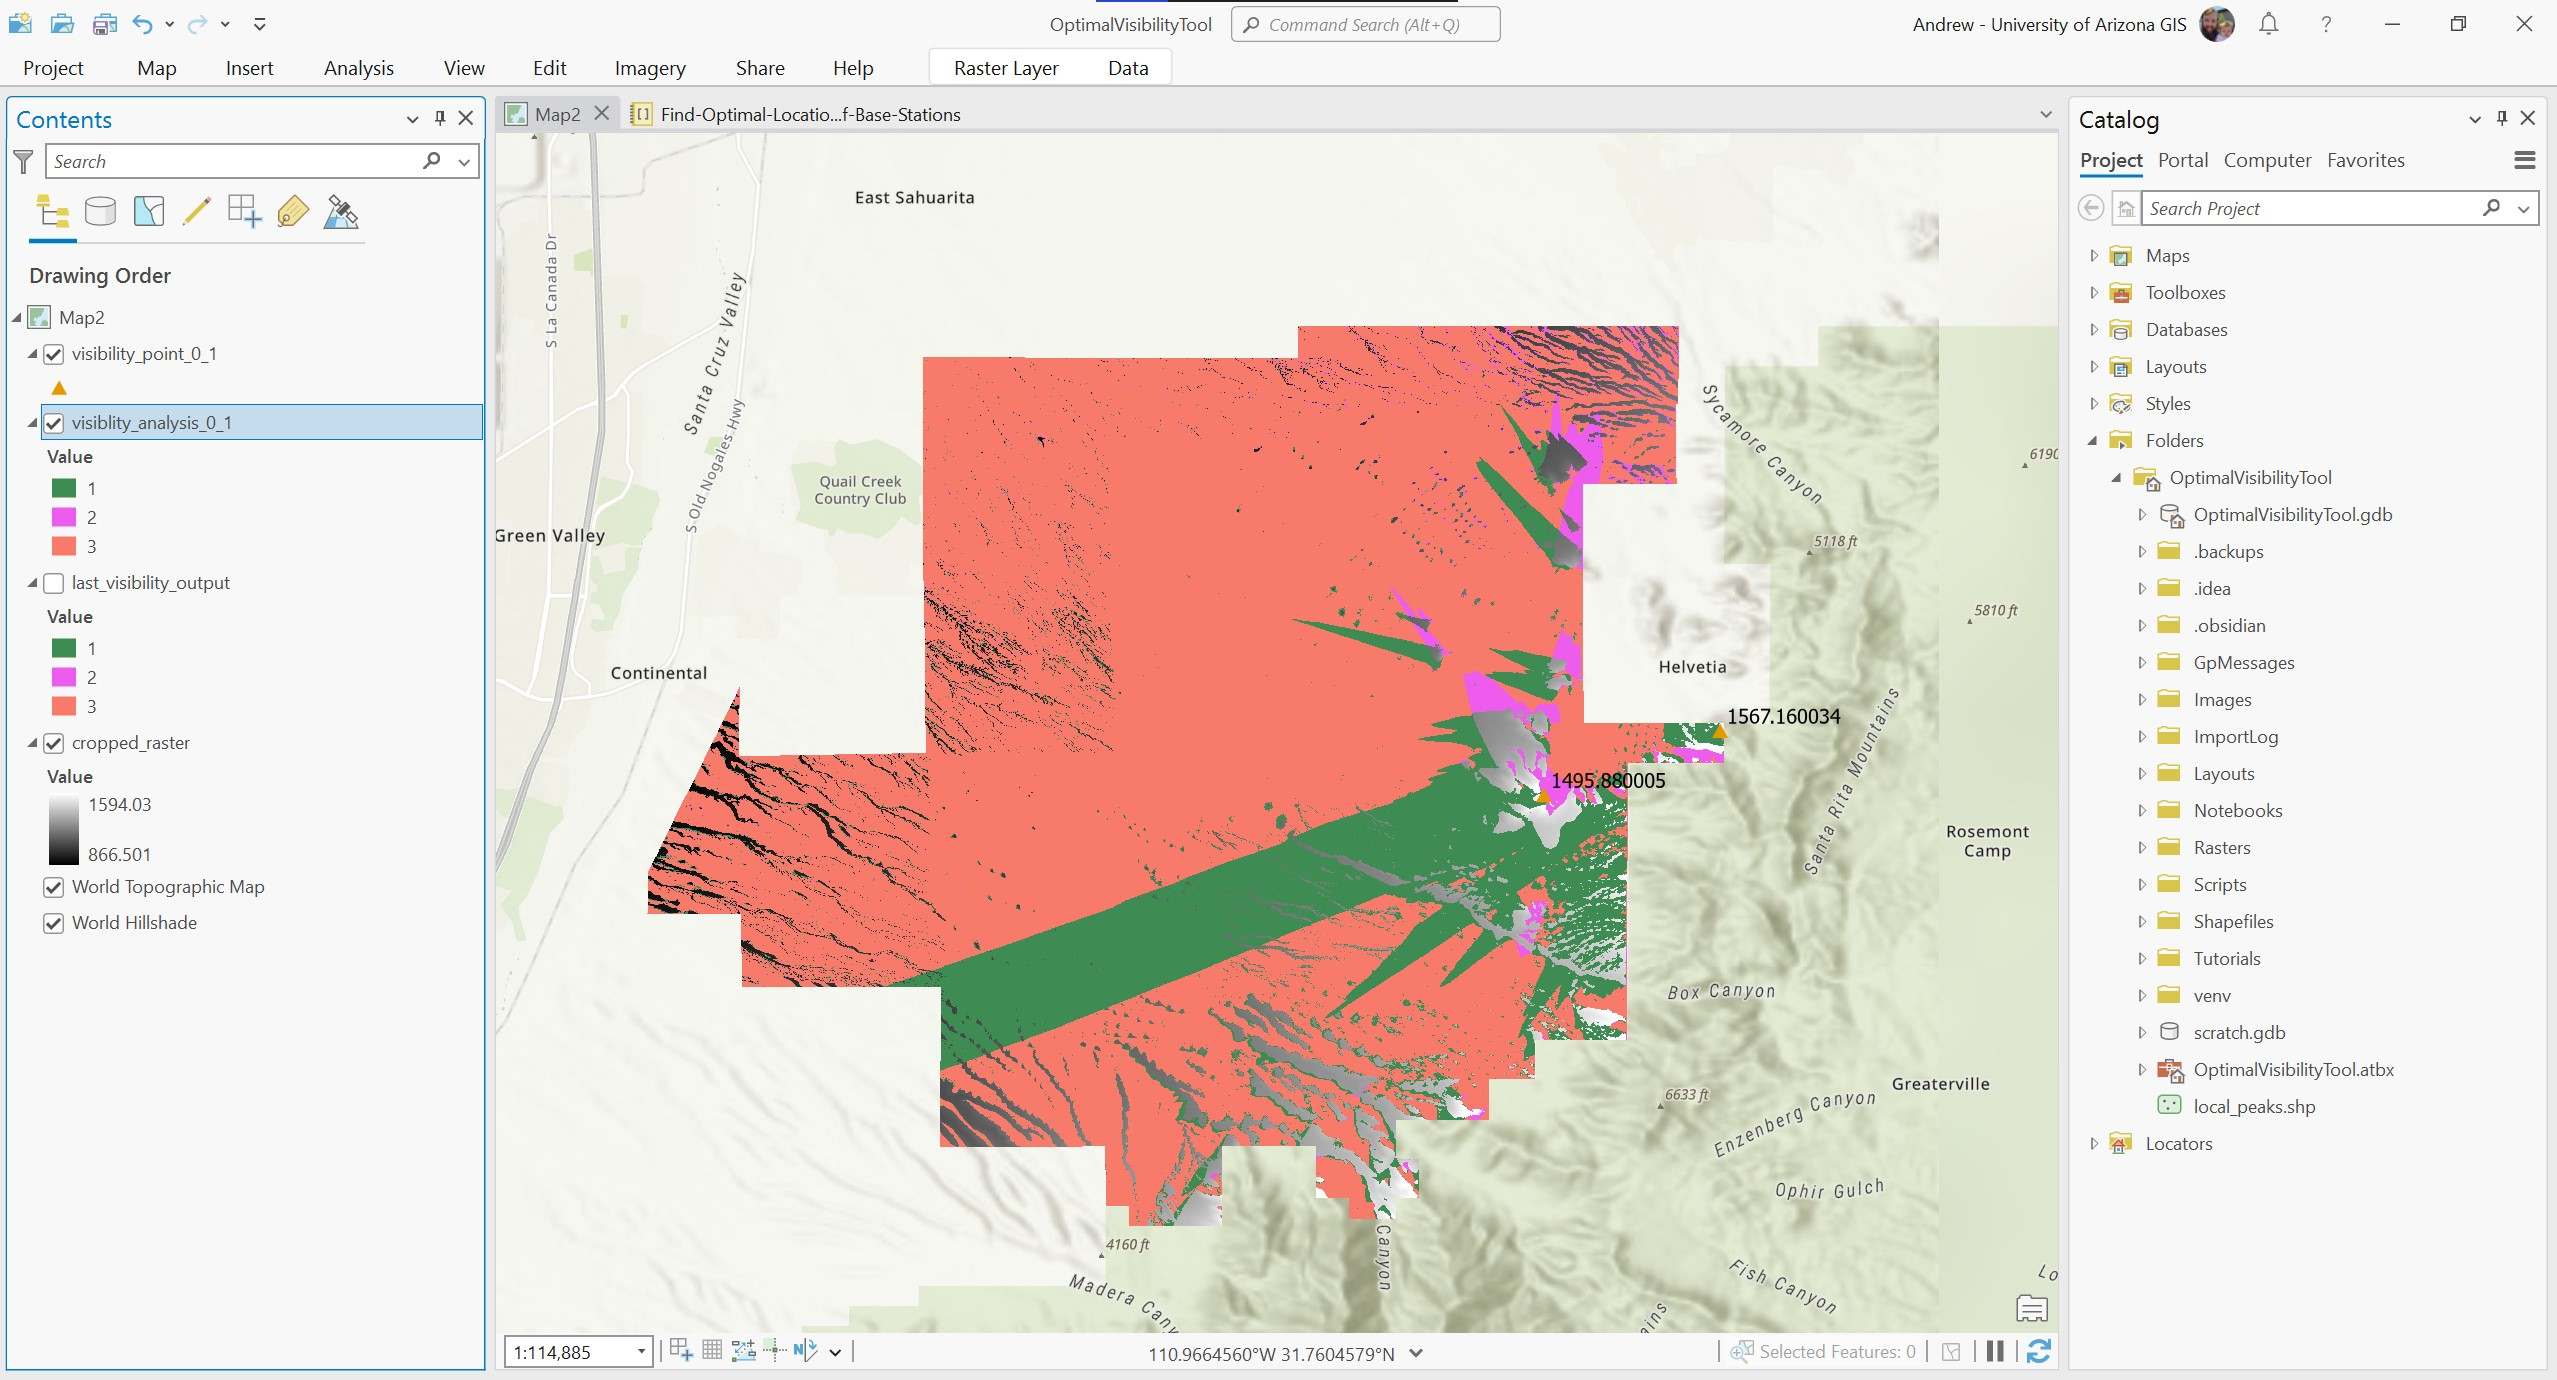

The next code chunk will determine which of the rasters has the maximum viewable area by counting the number of raster cells that were "visibile" from each point. The raster with the maximum viewable area is considered the optimal placement of the virtual fence base station.

In [ ]:
# initialize variables to keep track of the maximum count value 
# and the name of the raster with the maximum count value
# the raster with the maximum count value is the optimal base station location
max_count = -1
max_count_raster = ""

# change the Python working directory to save the CSV files in the "visibility_output_{}" folder
os.chdir(visibility_analysis_folder_path)

# Iterate through the list of rasters
for raster in rasters:
    # Create a unique filename for the output dataframe
    output_filename = f"{raster}_table.csv"

    # Get the raster attribute table as a table view
    table_view_name = f"{raster}_view"
    table_view = arcpy.MakeTableView_management(raster, table_view_name)

    # Get the Count value from each raster table using a SearchCursor
    count_field = "Count"
    with arcpy.da.SearchCursor(table_view, count_field) as cursor:
        count_values = [row[0] for row in cursor]

    # Find the maximum count value
    count_max = max(count_values)

    # Check if the Count value is greater than the current maximum count value
    if count_max > max_count:
        # If so, update the maximum count value and the name of the raster with the maximum count value
        max_count = count_max
        max_count_raster = raster

    # Convert the table view to a Pandas dataframe
    dataframe = pd.DataFrame.from_records(arcpy.da.TableToNumPyArray(table_view, count_field))

    # Save the dataframe to a file
    dataframe.to_csv(output_filename, index=False)

    # Print a message indicating the dataframe has been saved
    print(f"{output_filename} saved successfully.")

## How to Interpret the Results from This Analysis

This analysis outputs a raster for each pair of points with 3 bands:
- band 1 (green in the example below) corresponds to all of the raster cells that are visible from observer point 1 that are not also visible from observer point 2
- band 2 (pink in the example below) correponds to all of the raster cells that are visibile from observer point 2 that are not also visible from observer point 1
- band 3 (orange/red) corresponds to all of the raster cells that are visible to both observers

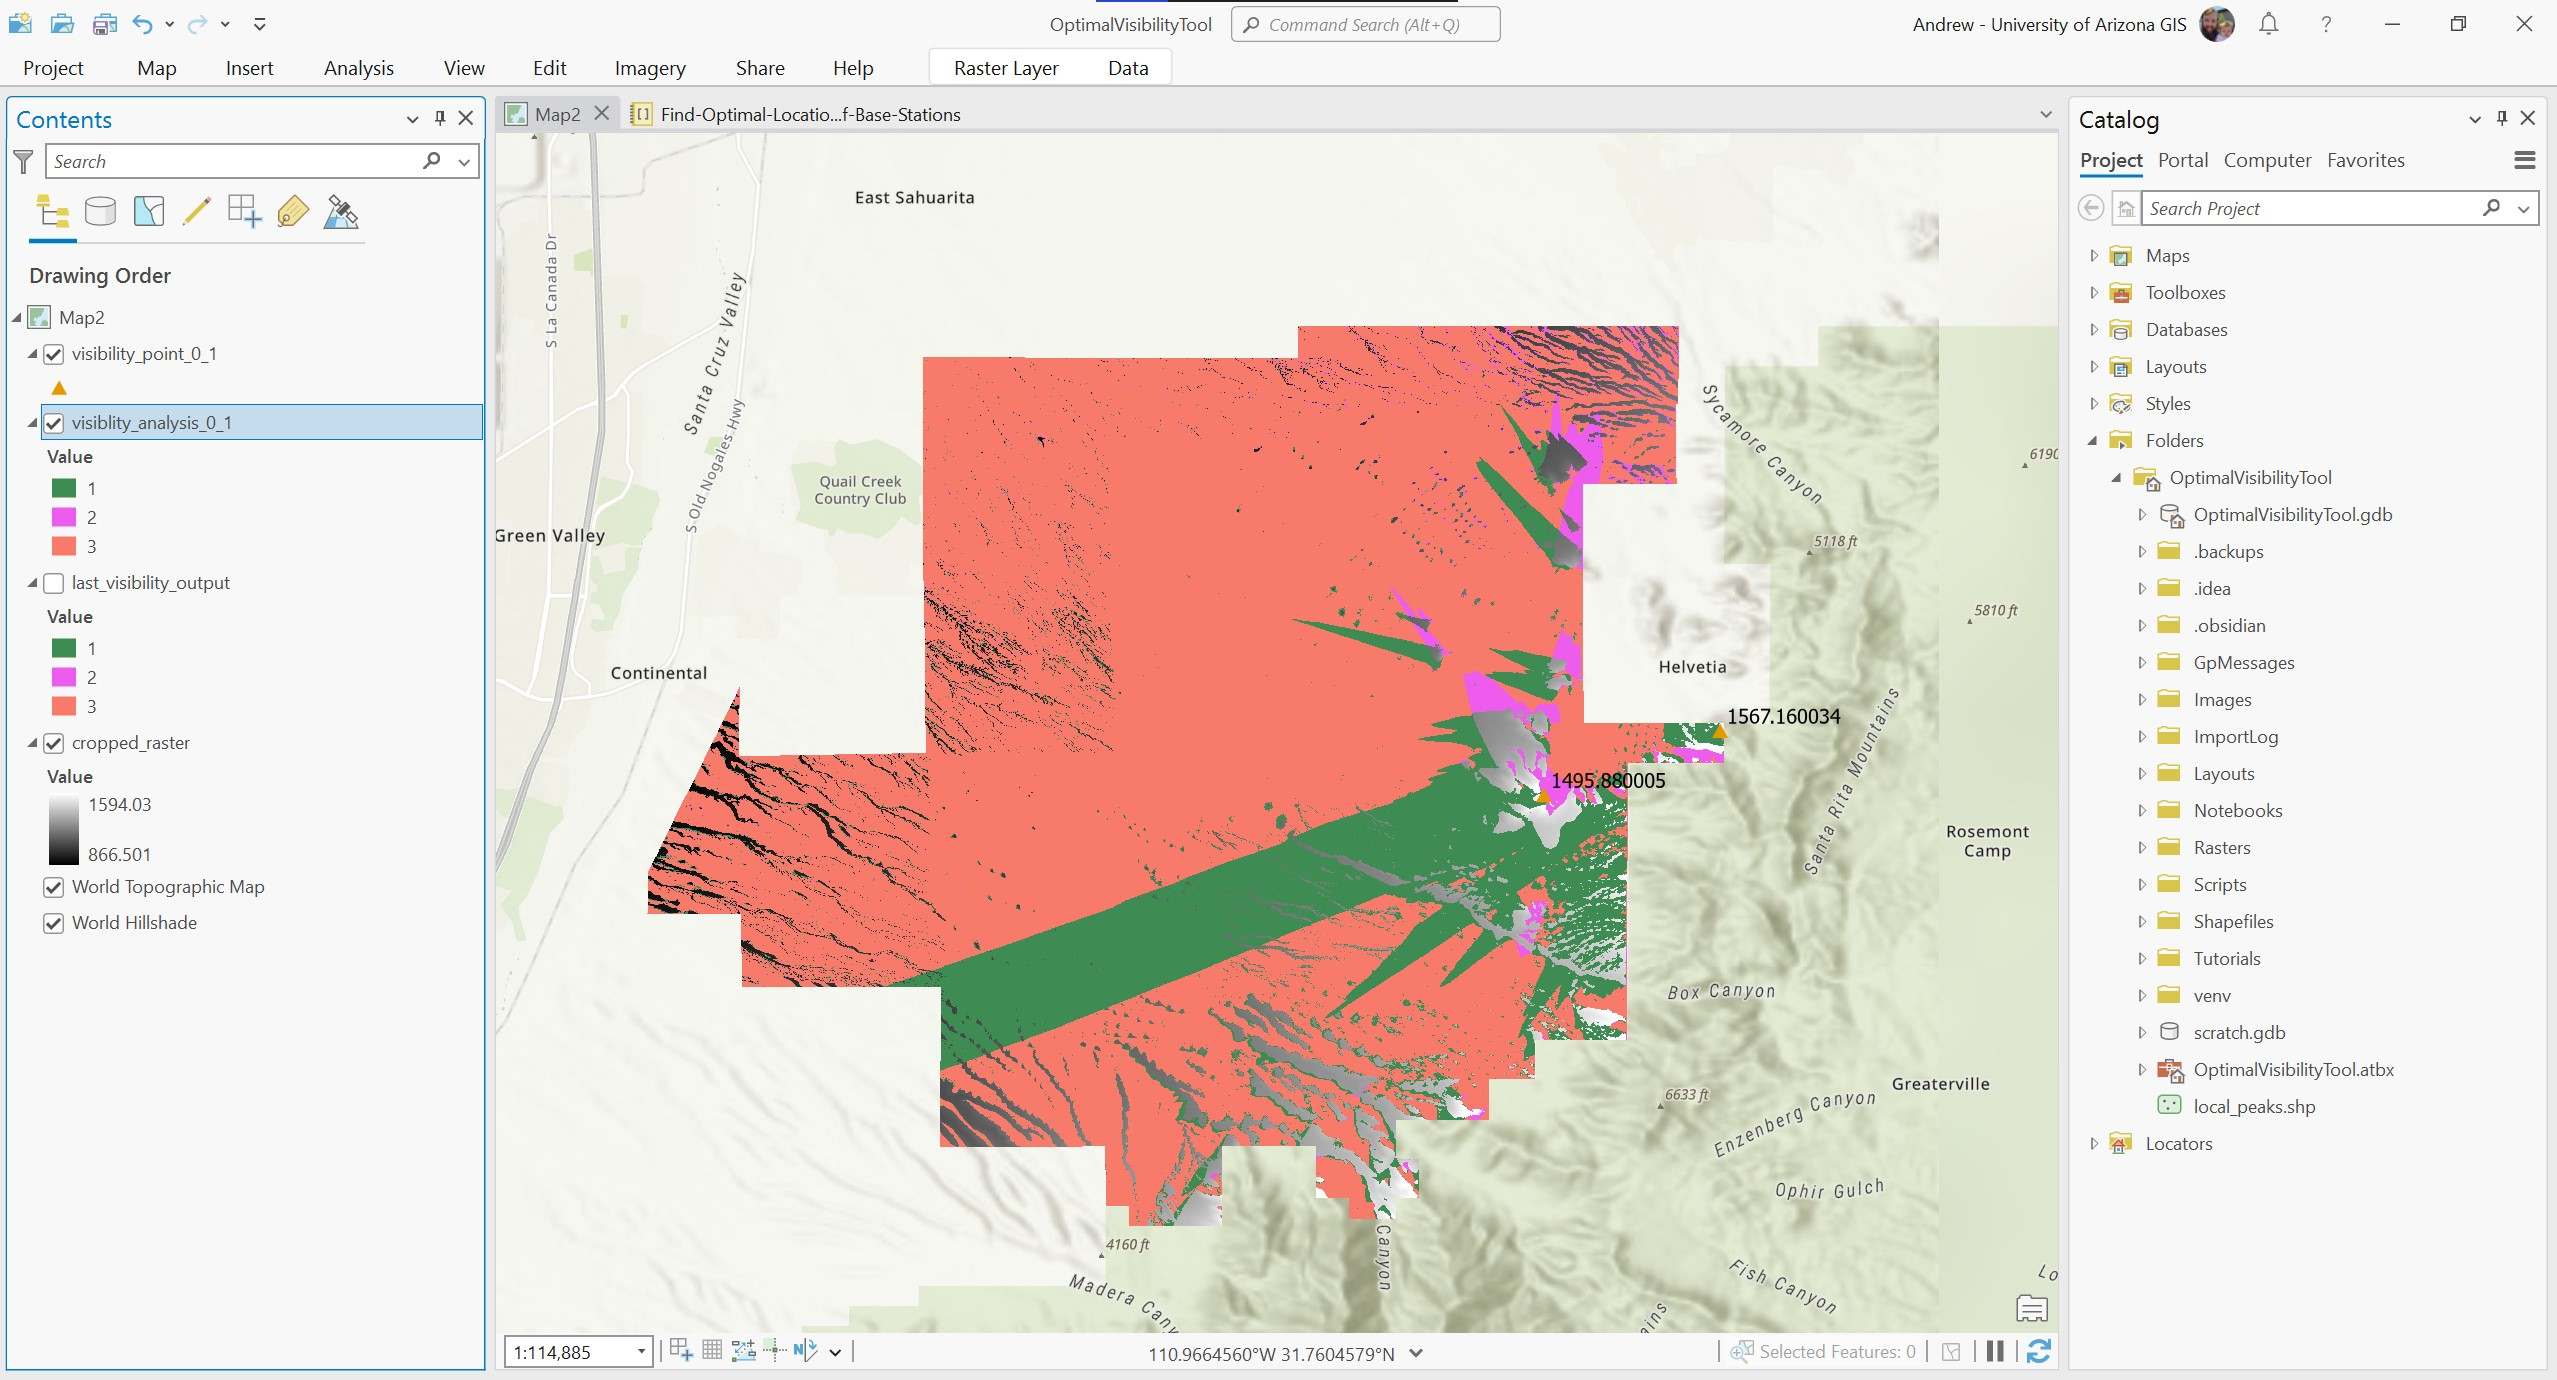

Each potential base station placement (i.e. the observers) contributes some to the total radio coverage for an area. To see how much each point contributes to the respective coverage, you can set the other bands to "no color" so only one band is visible. Right click on the raster band that you want to 'turn off' and select "no color".

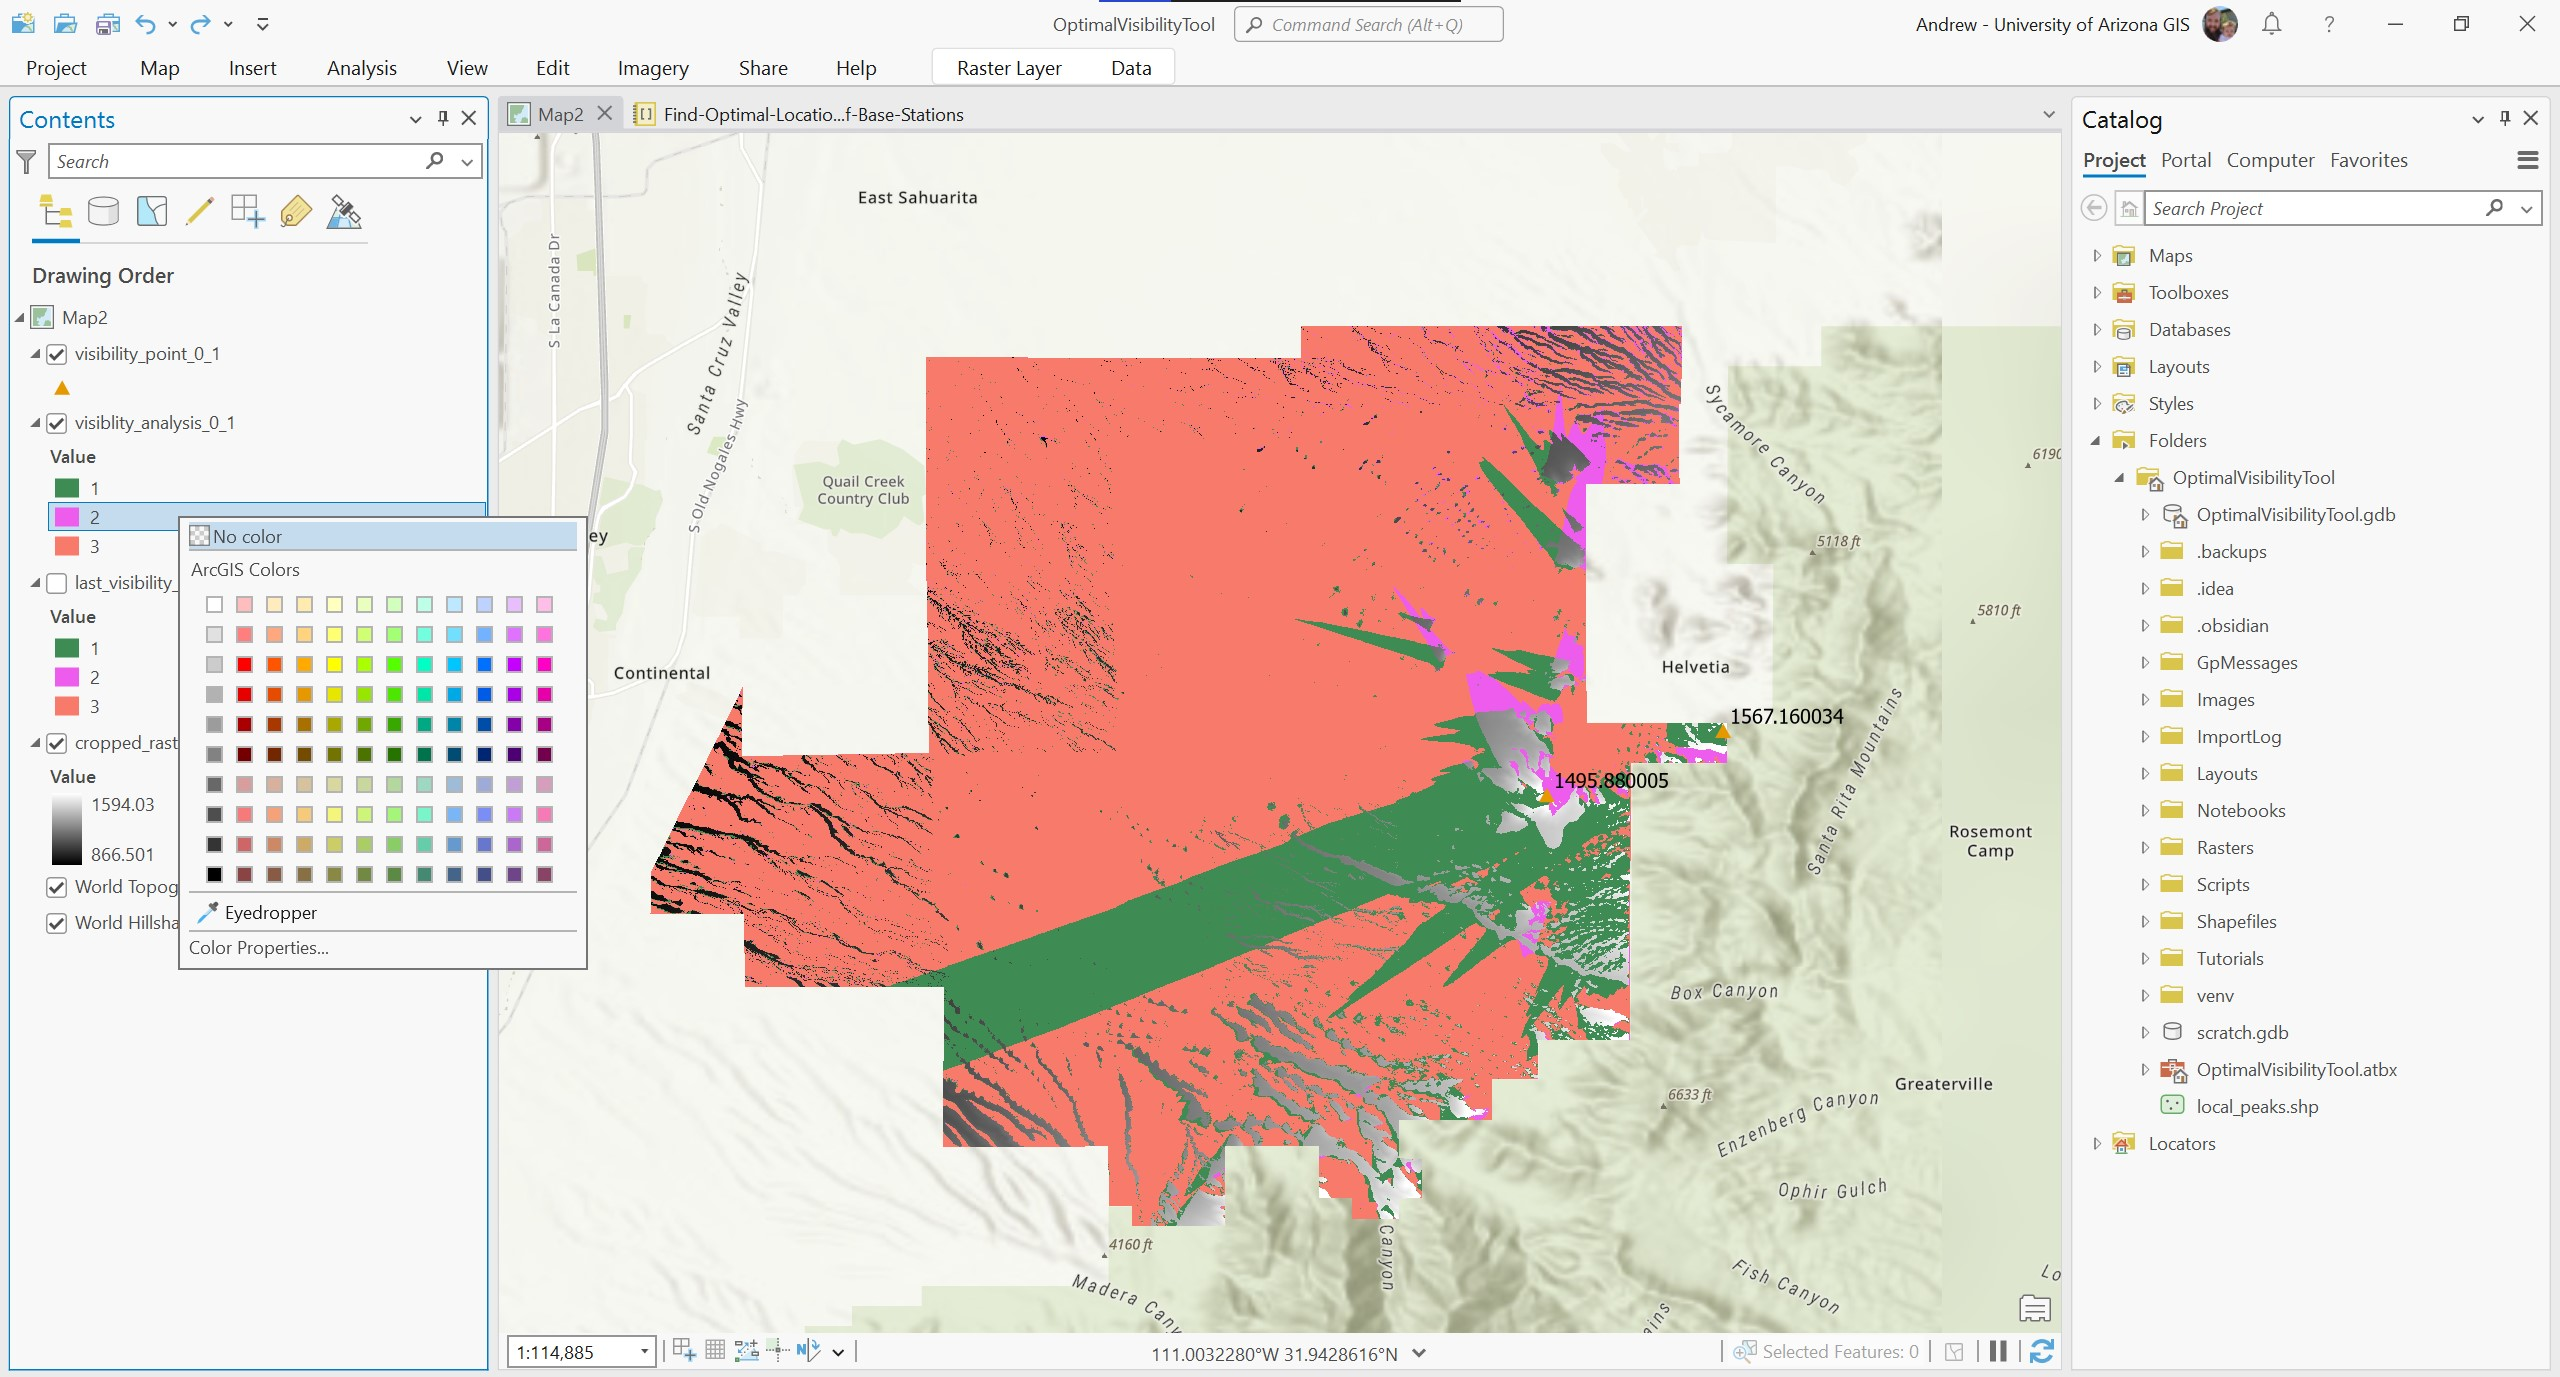

With bands 2 and 3 set to "no color" we can see what raster cells are visible only to visiblity point 0. Point 0 is highlighted in the attribute table and is represented by the teal triangle on the map.

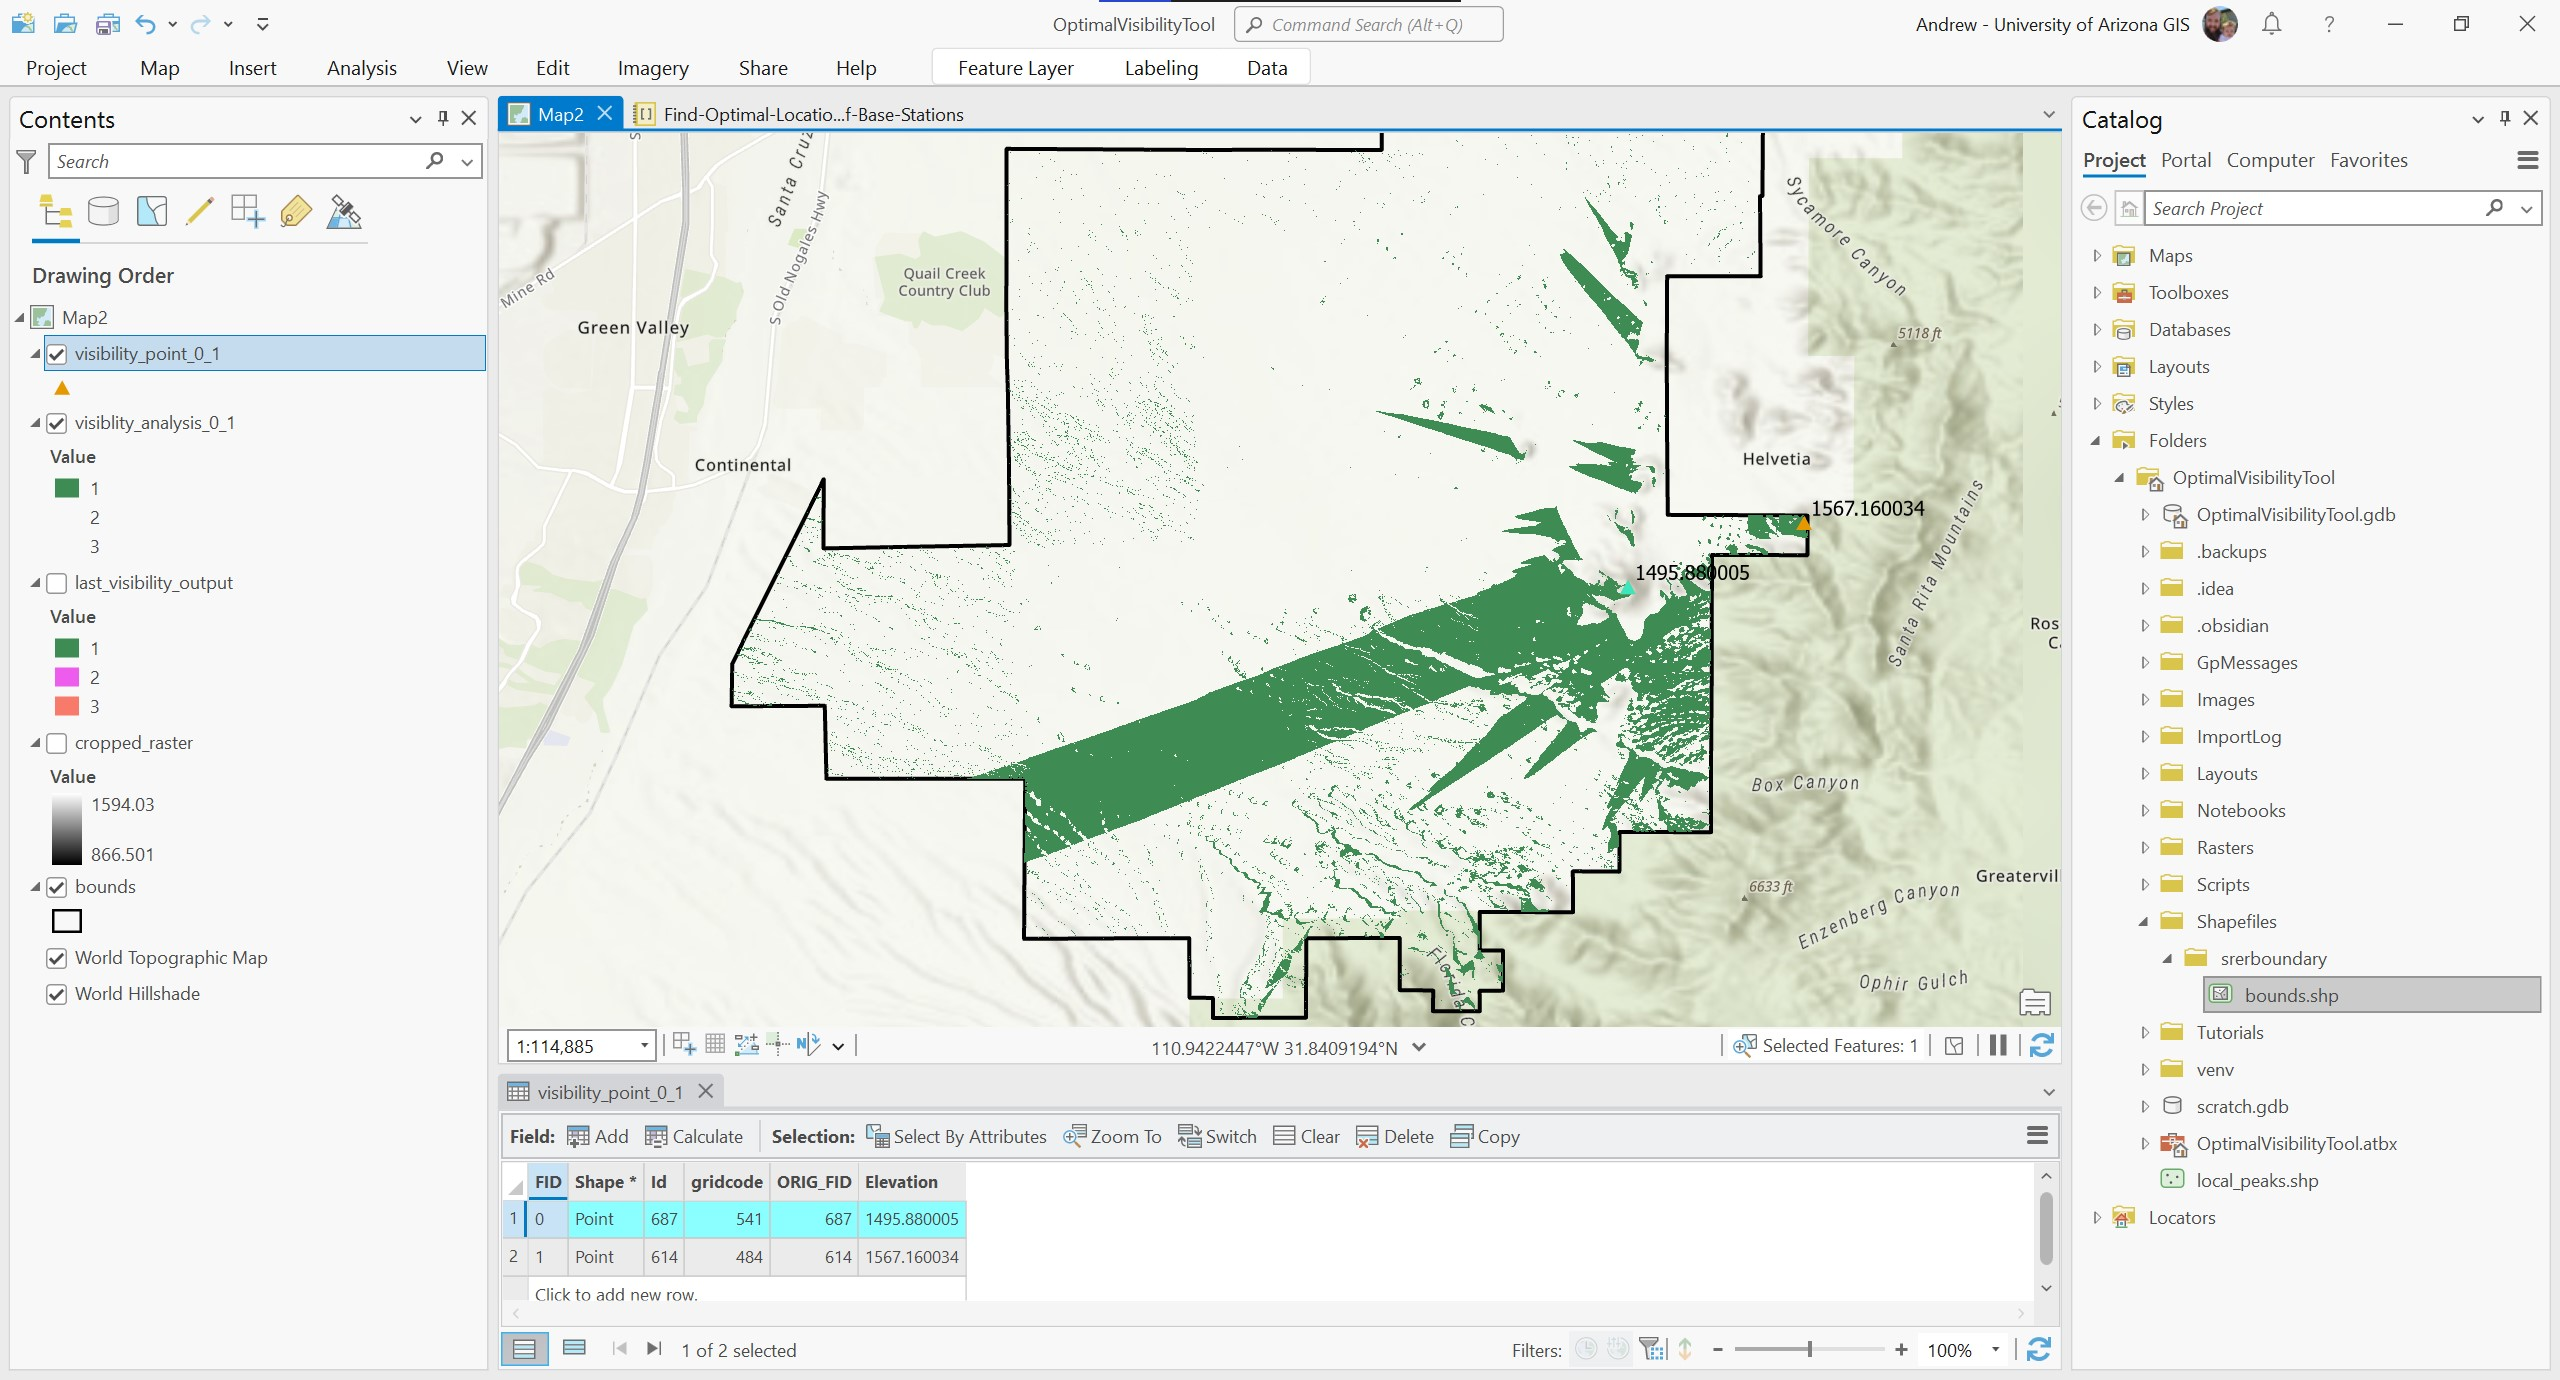

Next, set band 1 to "no color" and set band 2 to pink to see what visibility point 1 contributes to radio coverage. Band 2 contributes much less than band 1. In other words, you don't gain much additional coverage by adding a second base station at visibility point 1 (highlighted in the attribute table and represented on the map by the teal triangle).

An important question to ask is: how much coverage does the second base station contribute to the total coverage? If it's not much, then why go to effort to place it there? If it covers significant gaps in your area, then it might be worth the cost and effort to add the second base station.

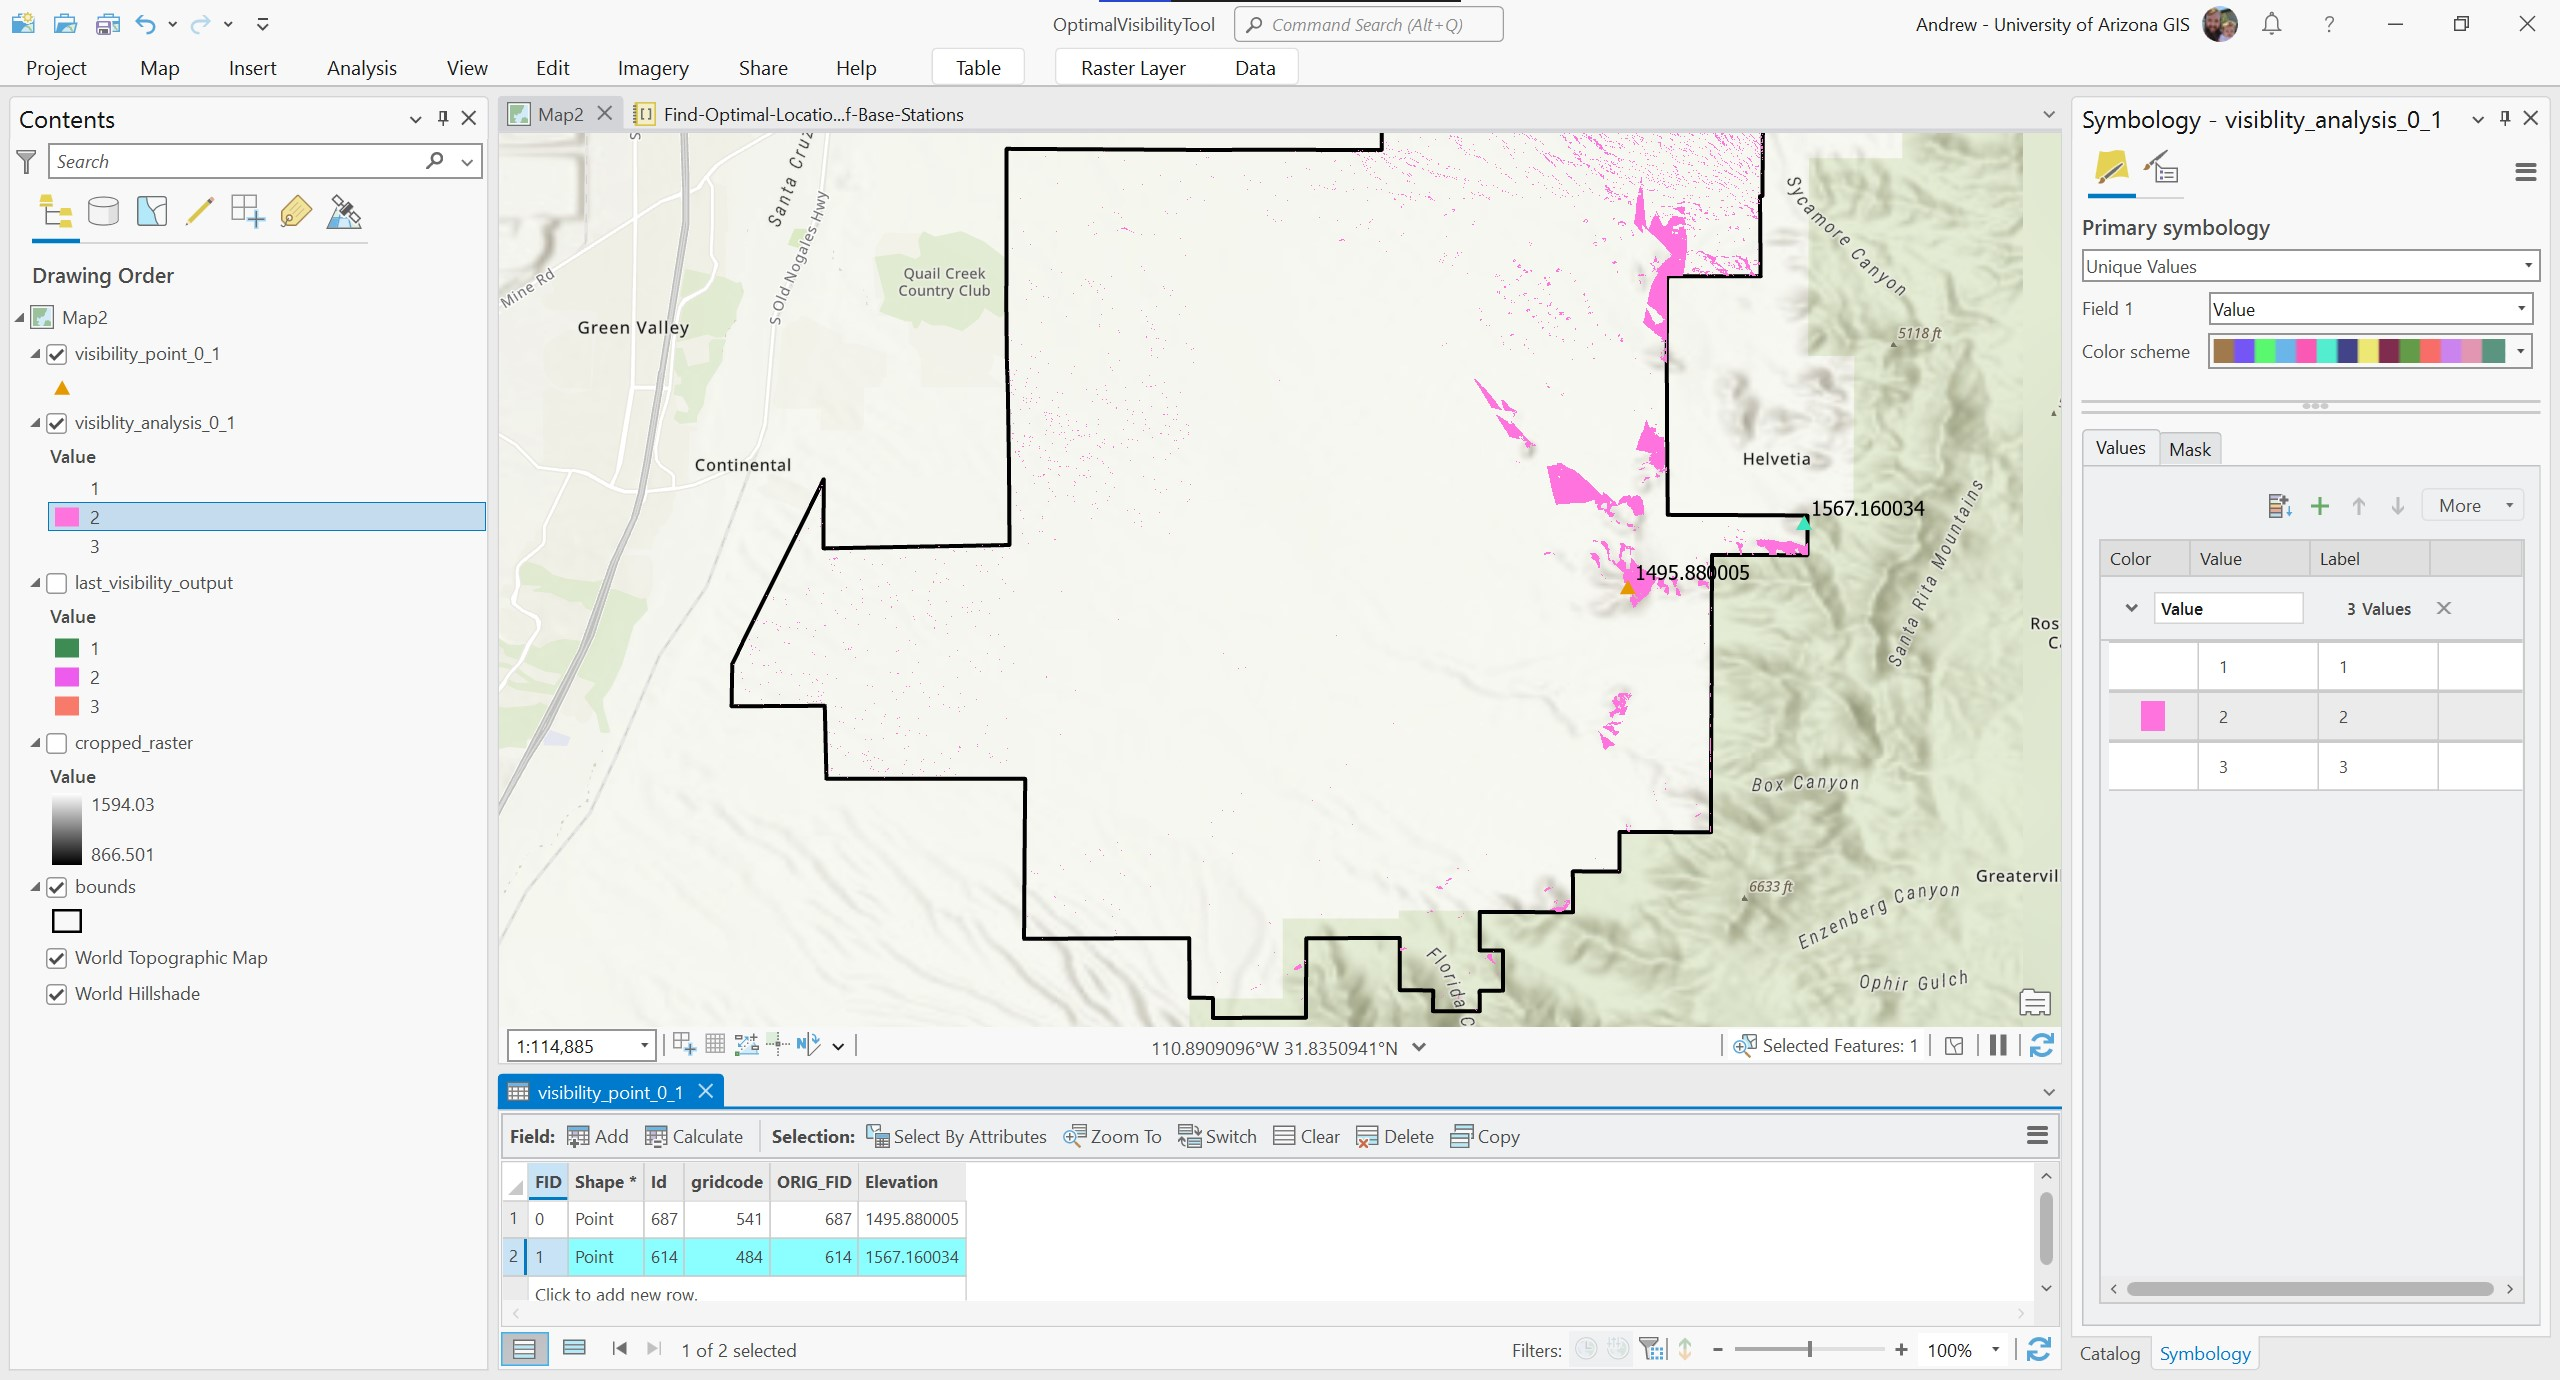

Next, set band 2 to "no color" and set band 3 to red. Band 3 represents the raster cells that are visible by both points. In other words, it represents the area that would have radio coverage by both base stations. Having overalping coverage is desireable, because virtual fence collars broadcast radio signals in all directions, and having overlapping coverage means the virtual fence collar data has a better chance of reaching at least 1 base station.

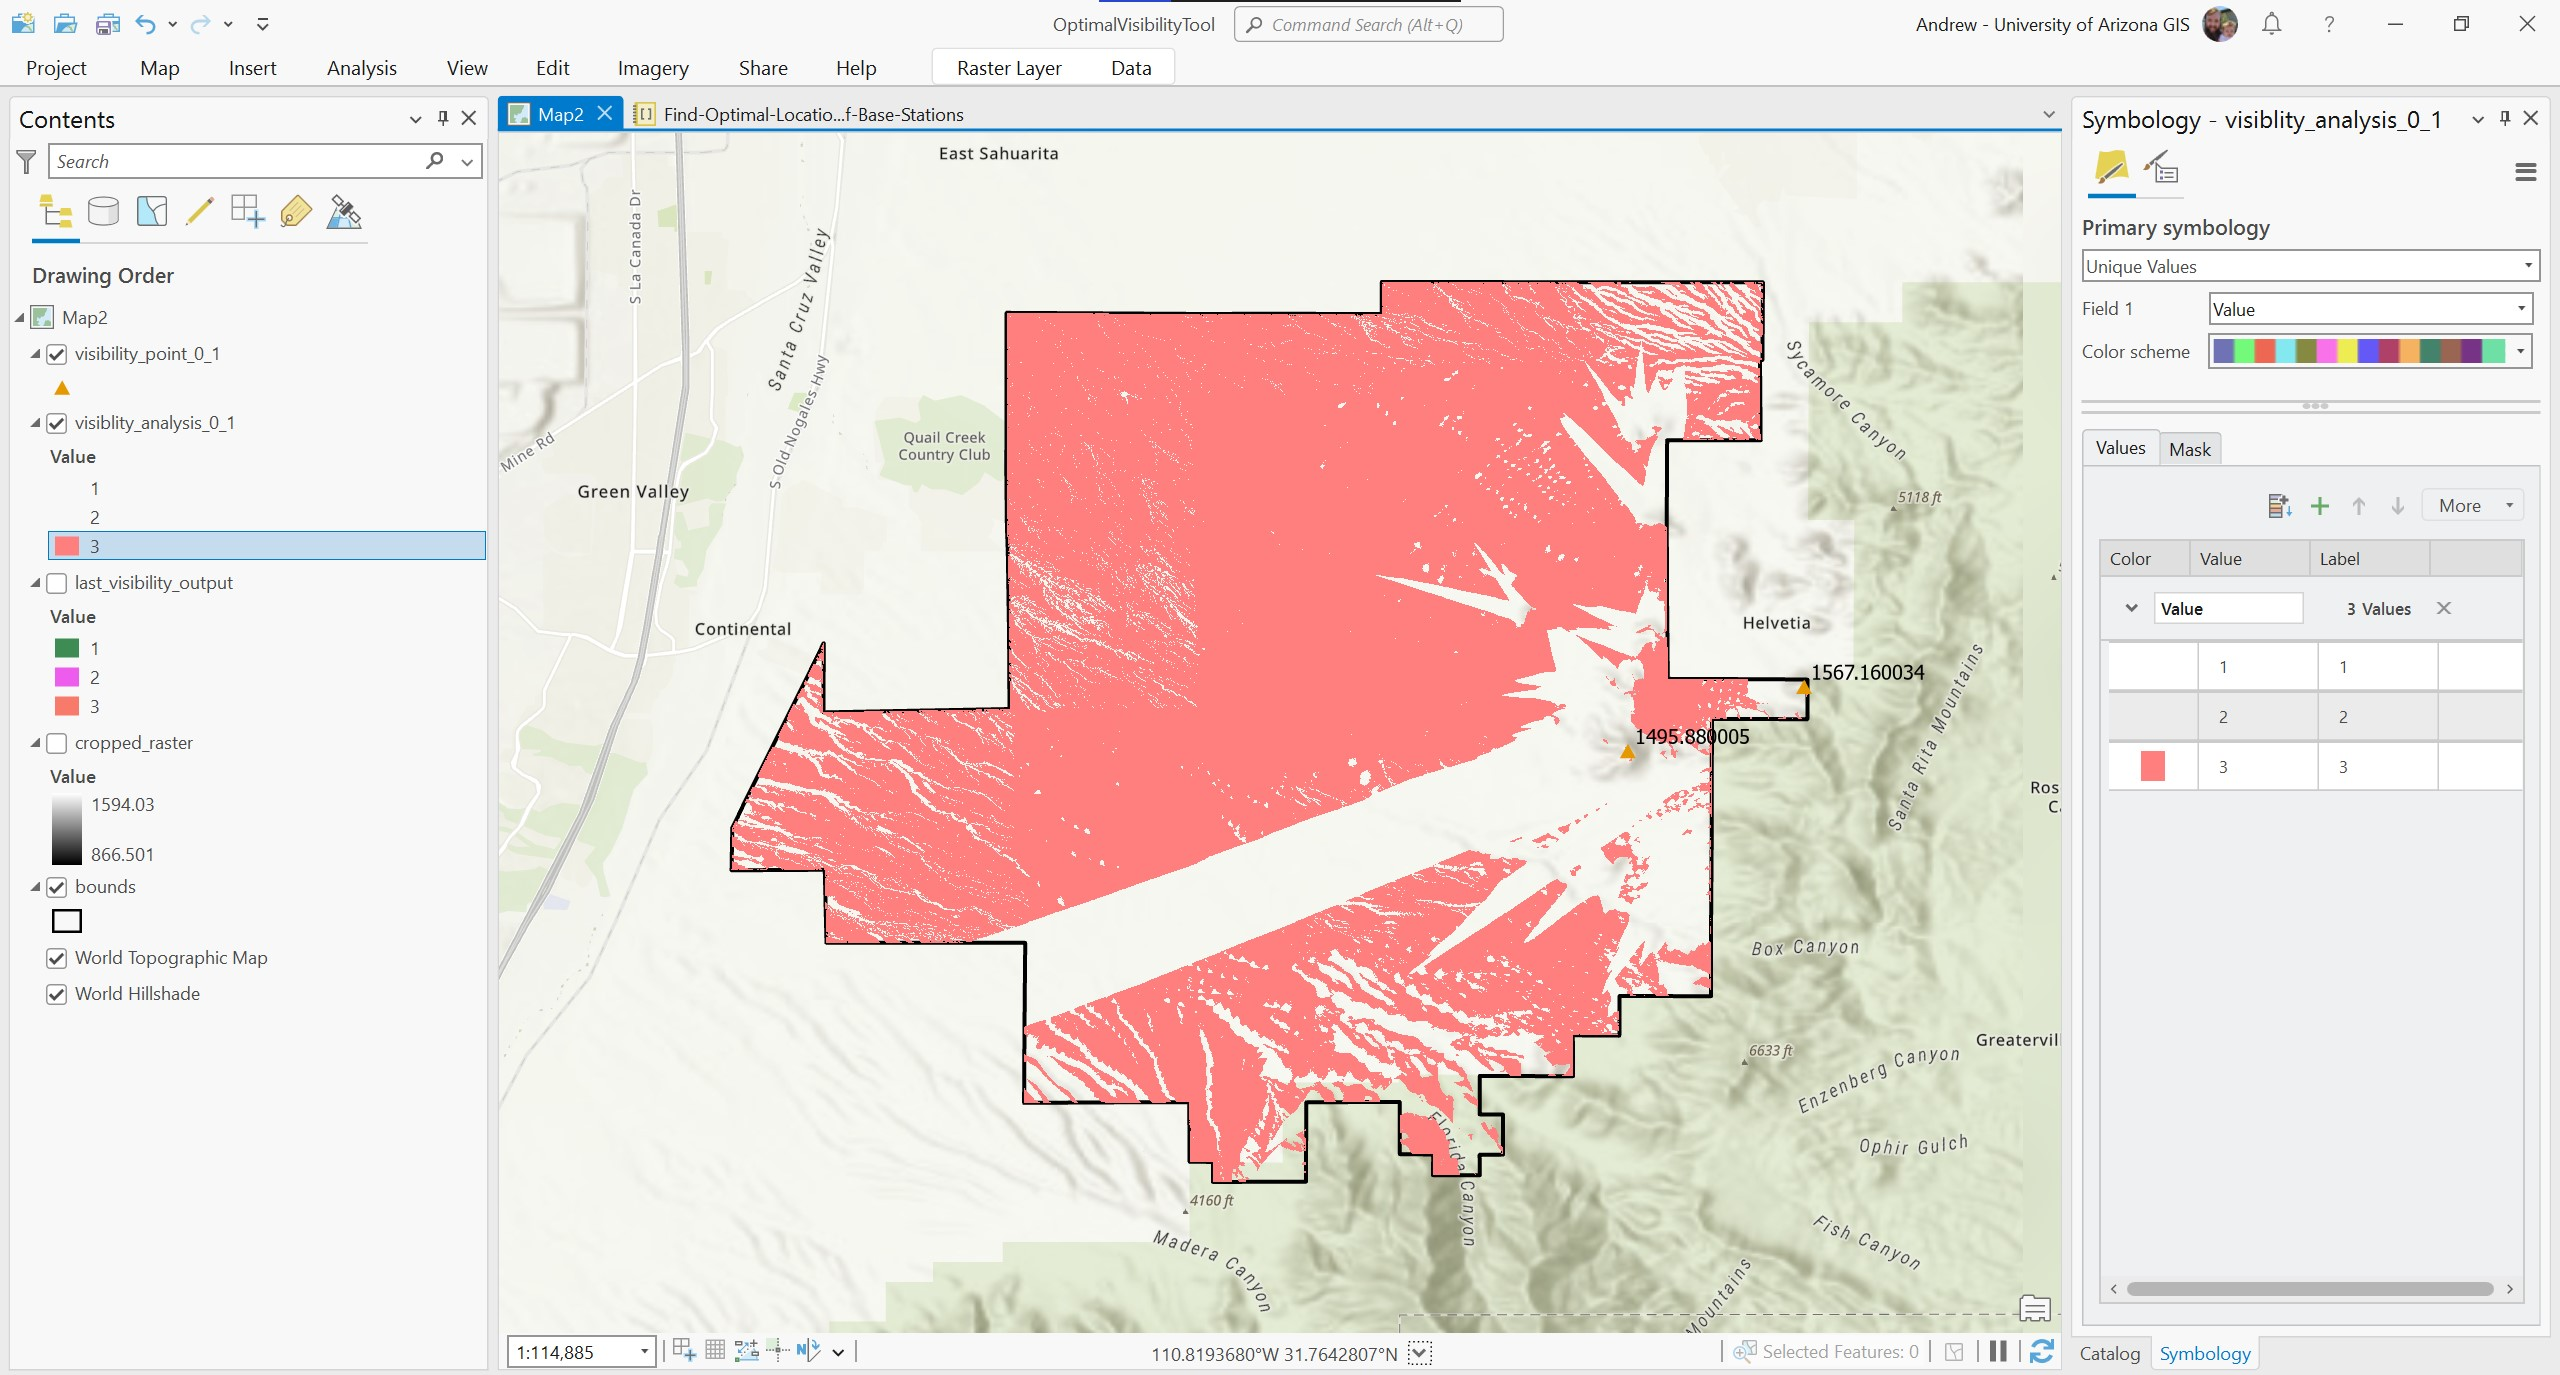

With all bands set to back to their orginal colors, this represents the total coverage provided by two virtual fence base stations. The uncolored areas represent areas potentially without radio coverage.

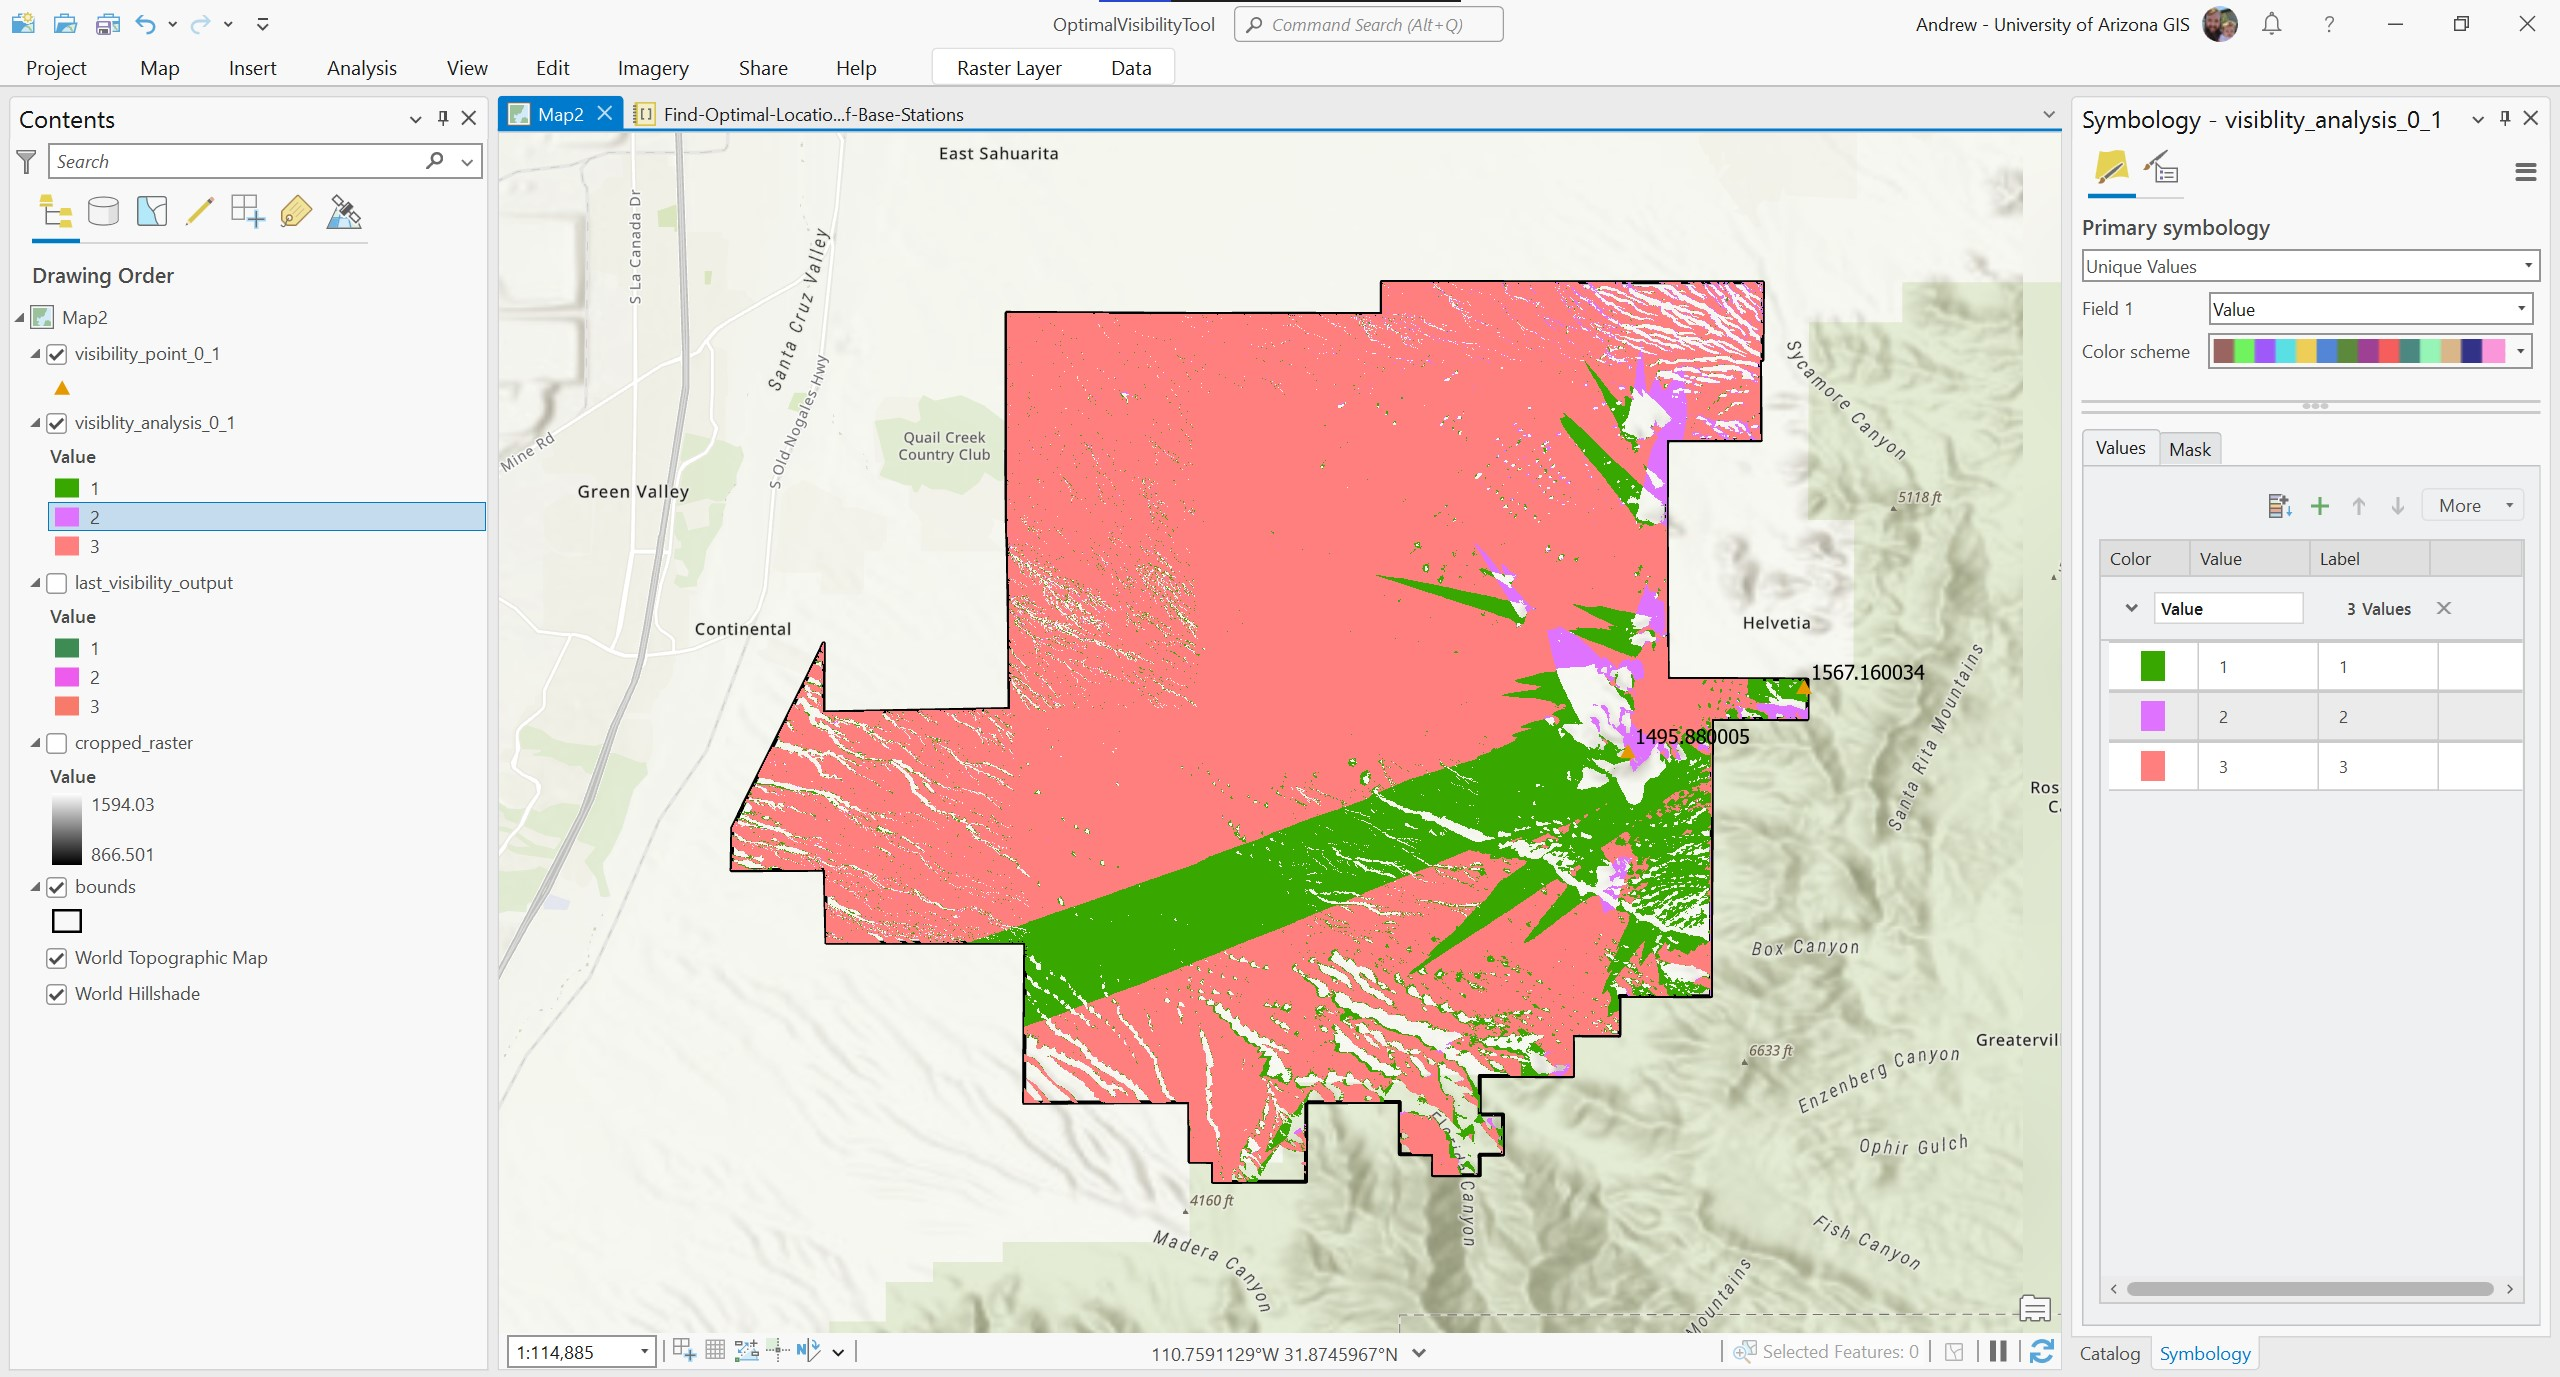

Each raster generated by this analysis also has a corresponding CSV file with number of raster cells that are visibile from each point. You can open them as a new tab in ArcGIS Pro by right clicking on them and selecting "Open". In the example image below, Point 0 contributes 380,705 raster cells while Point 1 contributes 49,699 raster cells, which is much less than Point 1. The amount of raster cells visible by both points is 1,738,102.

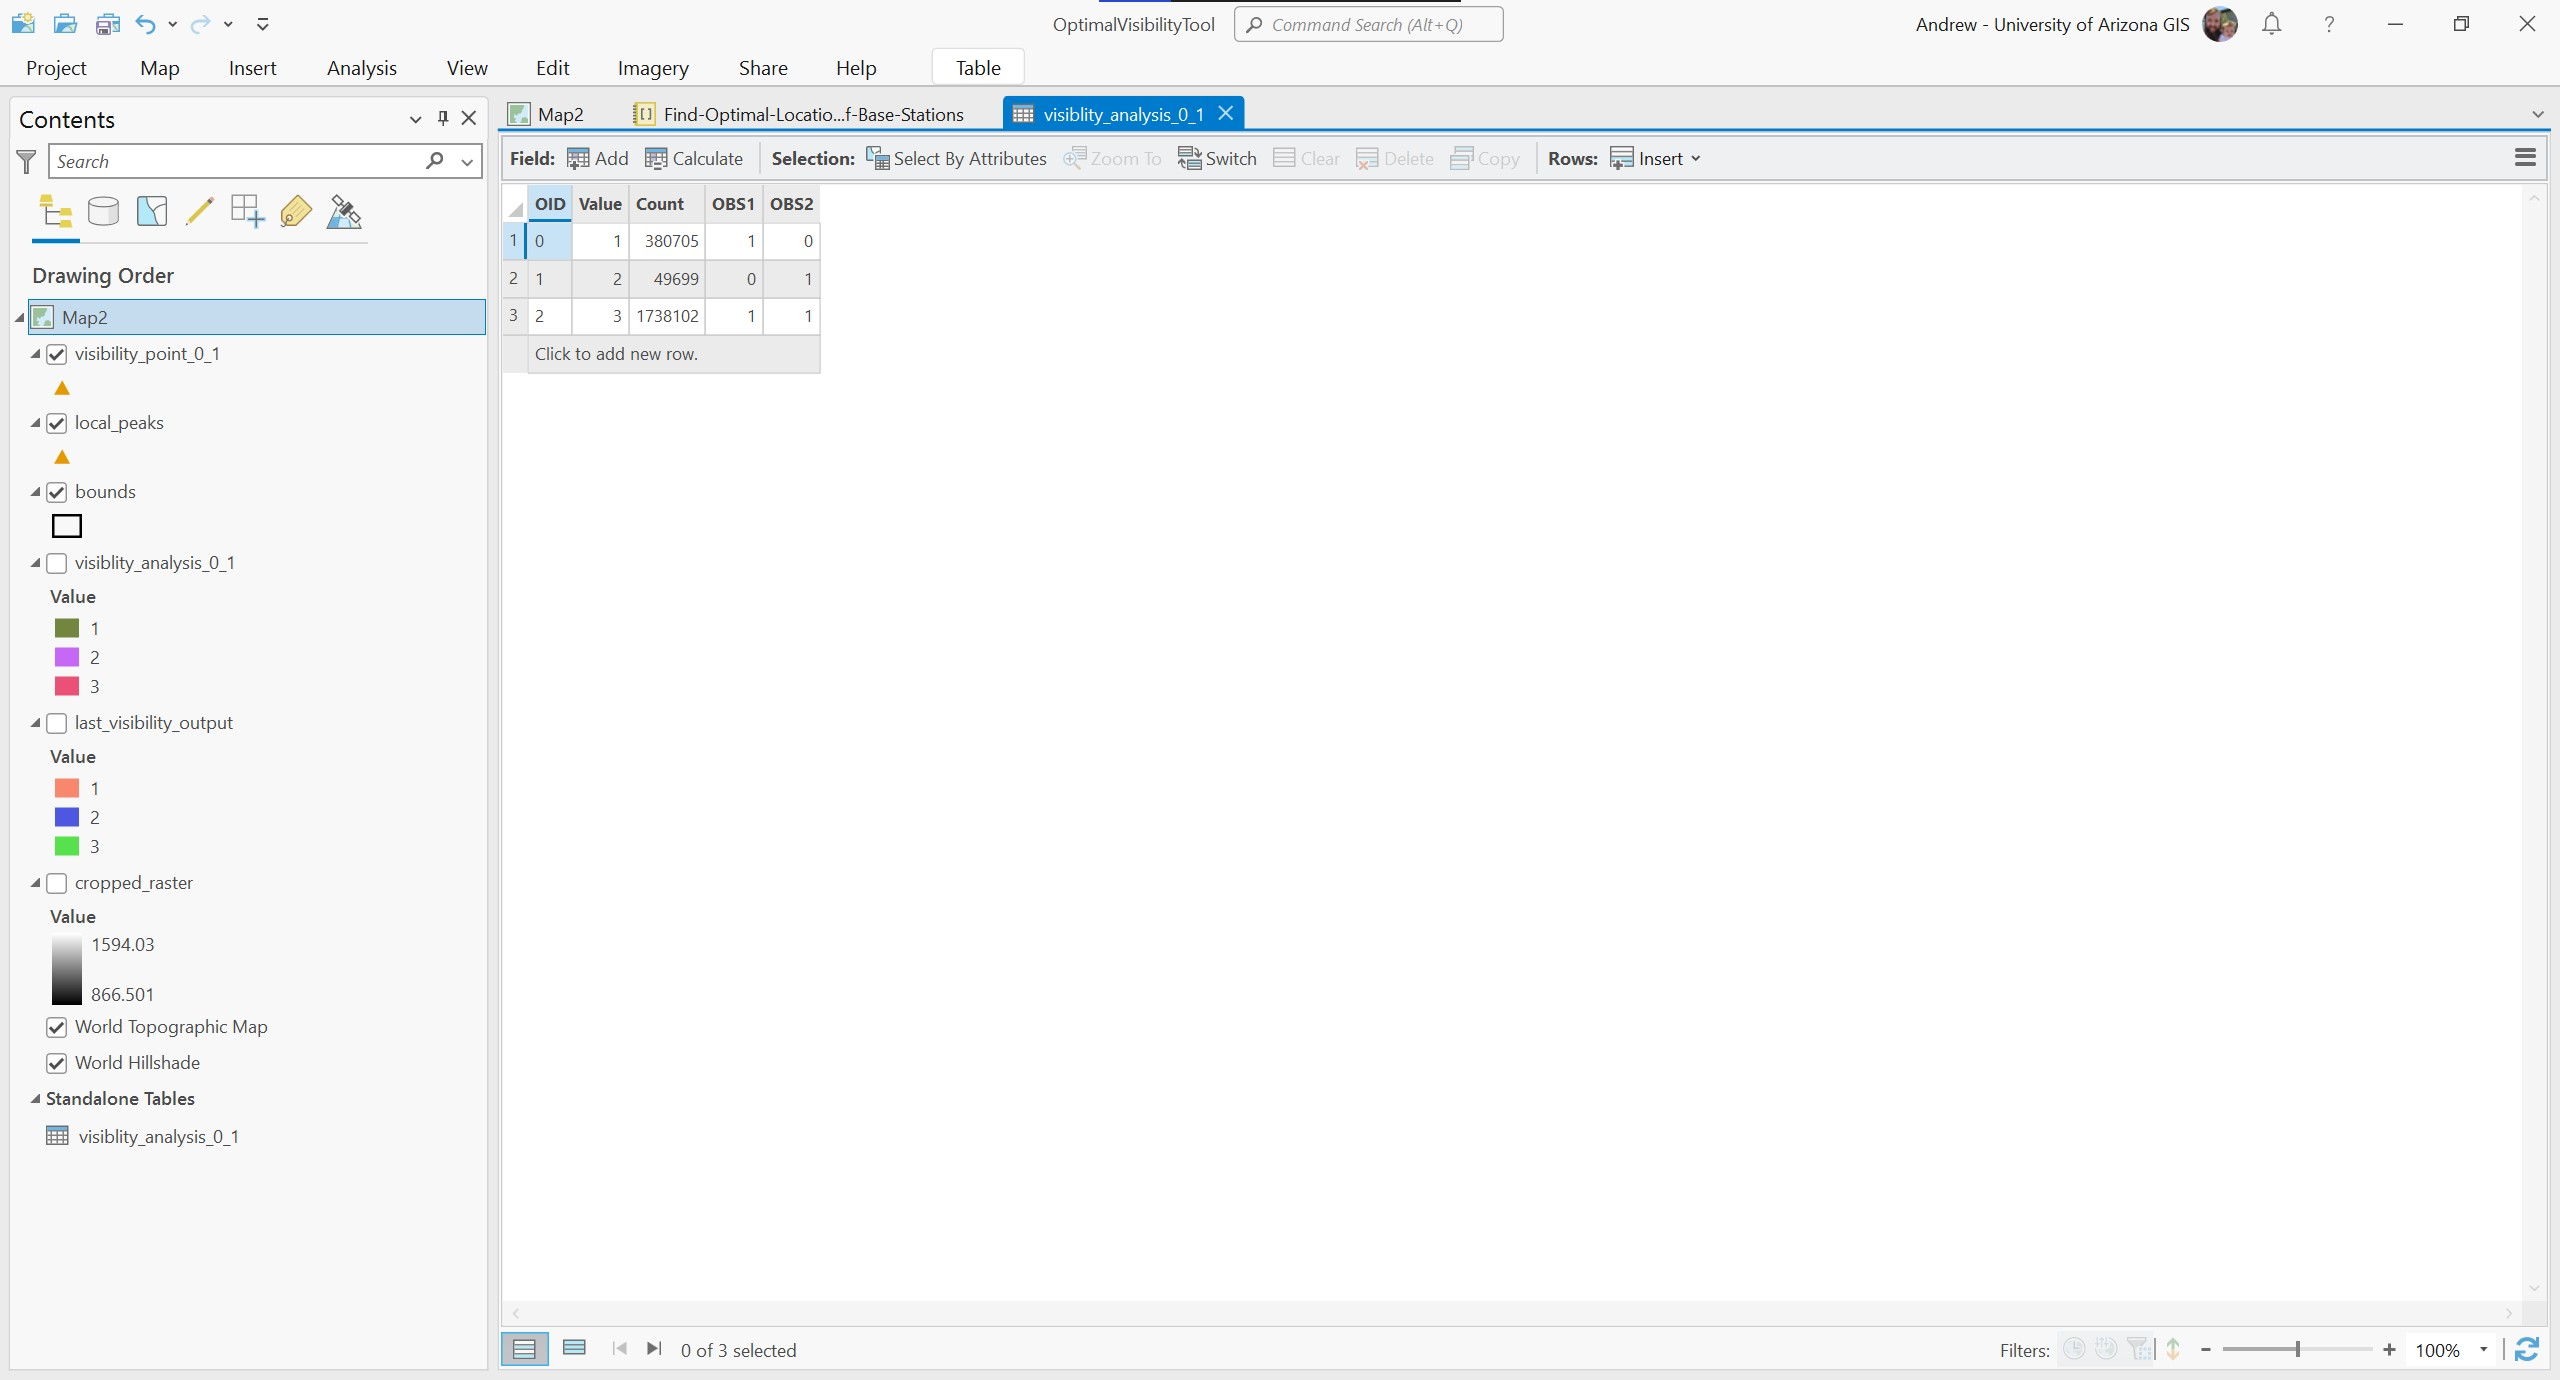

The next code chunk will tell you the name of the raster that has the highest visibility, as well as the number of raster cells that are visible from that point. This is considered the 'optimal' location to place the virtual fence base station for your area. However, practical limitations such as distance from roads and terrain may affect the actual placement of the base station. A process of elimination by throwing out the points that are not practical to access might help you narrow down your potential placements for your virtual fence base station.

In [208]:
# Print the name of the raster representing the optimal base station placement
print(f"Raster with the highest visibility is {max_count_raster} with a count of {max_count}")

Raster with the highest visibility is visiblity_analysis_0_1.tif with a count of 2098993.0


This visibility analysis is our best aproximation of radio coverage, as we are assuming that line of sight from the base station is the primary factor in determining good radio coverage. Many other factors including atmospheric conditions, signal attenuation and reflectance, and vegetation cover are likely to affect radio coverage.